# Introduction

<b>Problem Statement

A portuguese bank has onboarded 8000 new customers through acquiring a smaller bank. The bank launches a telemarketing campaign to incite these customers to subscribe to a term deposit. Due to budget and ressource constraints, only 2500 of these new customers can be contacted in this initial stage.

Using data from UCI repository which contains customer and outcome data of the campaigns, the goal is to identify which of the 2500 customers to contact to maximise revenue and provide recommendations for future campaigns.

What is a term deposit?

"A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. Term deposit investments usually carry short-term maturities ranging from one month to a few years and will have varying levels of required minimum deposits. The investor must understand when buying a term deposit that they can withdraw their funds only after the term ends. In some cases, the account holder may allow the investor early termination—or withdrawal—if they give several days notification. Also, there will be a penalty assessed for early termination."
(https://www.investopedia.com/terms/t/termdeposit.asp)

----------

A successful subscriber means revenue for the Portuguese bank. Based on domain knowledge, we can estimate the value of subscription at €100.

    **- Expected Revenue = (#customers contacted * value of subscription) * proportion of successful calls)**

In general, we know that uptake for these type of campaigns is small, with the proportion of successful calls around 10-15%.

As such, by contacting 2500 customers randomly, we would expect revenue to be between EUR 25.000 and EUR 37.500.

However by using predictive modeling techniques and selecting the 2500 customers carefuly, more revenue can be generated.

<b>Methodology

CRISP-DM will be employed for this project, which involves:

    1-Business Understanding
Most of the data mining processes aim to provide a solution to a problem. Having a clear understanding of the business objectives, assessment of the current situation, data mining goals and the plan of development are fundamental to the achievementof the objectives

    2- Data Understanding
Once the business context and objectives are covered, data understanding considers data requirements. This step encompasses data collection and data quality verification. At the end of this phase, a preliminary data exploration can occur.  

    3- Data Preparation
In this step, the data cleaning techniques are applied to prepare the data to be used as input for the modelling phase. A more thorough data exploration is carried during this phase providing an opportunity to see patterns based on business understanding.

    4- Modelling
The modelling stage uses data mining tools to apply algorithms suitable to the task at hand. The next section of this report is dedicated to detail a few techniques applied during this step.

    5- Evaluation
The evaluation of the models is done by taking into account several evaluation metrics and comparing the performance of the models built during the modelling phase. This step should also consider the business objectives when choosing the final model. 

    6- Deployment
The knowledge discovered during the previous phases need to be reported to the management and be applied to the business environment. Additionally, the insights gained during the process might change over time. Therefore, it is critical that the domain of interest be monitored during its period of deployment.

<font size="5">Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
chosen_palette = 'Paired'
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb


from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, \
precision_score, recall_score, roc_auc_score, classification_report, plot_confusion_matrix 

from sklearn.metrics import make_scorer, precision_recall_curve


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# do not show any warnings
import warnings
warnings.filterwarnings('ignore')

import time 

# set random state
random_state = 0

<font size="5">Data

The dataset was obtained from the UCI Machine Learning Repository. It will be further described in the case study.

Source: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

<font size="5">Load Data

In [2]:
raw_df= pd.read_csv(r'C:\Users\rol3x\MAIN_PATH\bank-modified.csv',delimiter =';')
raw_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,offer
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,no


In [3]:
#drop "offer" variable, since we wont be needing it for response modeling
# Drop pdays feature
raw_df = raw_df.drop('offer', axis = 1)

In [4]:
# Get info
raw_df.shape

(41188, 21)

We see that we have 21 columns, with 20 feature columns and 1 target column "y". There are 41,188 entries recorded.

<font size="4"><b>Data Dictionnary

We have been provided with the following information regarding the features.

age - (numeric)

job - type of job (categorical: "admin.","blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")

marital - marital status (categorical: "divorced", "married", "single", "unknown"; note: "divorced" means divorced or widowed)

education - (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")

default - has credit in default? (categorical: "no", "yes", "unknown")

housing- has housing loan? (categorical: "no", "yes", "unknown")

loan- has personal loan? (categorical: "no", "yes", "unknown")

contact - contact communication type (categorical: "cellular", "telephone")

month - last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

day_of_week - last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")

duration - last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

campaign - number of contacts performed during this campaign and for this client (numeric, includes last contact)

pdays - number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

previous - number of contacts performed before this campaign and for this client (numeric)

poutcome - outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

emp.var.rate - Employment variation is the variation of how many people are being hired or fired due to the shifts in the conditions of the economy. - quarterly indicator (numeric)

cons.price.idx - The Consumer Price Index (CPI) is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care. It is calculated by taking price changes for each item in the predetermined basket of goods and averaging them. - monthly indicator (numeric)

cons.conf.idx - Consumer confidence index (CCI) This consumer confidence indicator provides an indication of future developments of households' consumption and saving, based upon answers regarding their expected financial situation, their sentiment about the general economic situation, unemployment and capability of savings. - monthly indicator (numeric)

euribor3m - The 3 month Euribor interest rate is the interest rate at which a selection of European banks lend one another funds denominated in euros whereby the loans have a maturity of 3 months. - daily indicator (numeric)

nr.employed - number of employees - quarterly indicator (numeric)

The target variable "y" is whether the client subscribed to a term deposit (binary: "yes", "no")

offer - whether a offer was made or not to a customer (binary:"yes, "no") * only used in uplift modeling ; drop in business scenario 1.

<font size="4"><b>Train-Test Split

Split the data into test and training sets. This test set will be use to evaluate the final model. It represents the 8000 new customers the bank has acquired, as explained in the problem statement.

Ensure that the target variable "y" classes are proportional in the test set. Based on the proportion of responses, it is suspected that the classes will be unbalanced, with "yes" being a minority class.

In [5]:
# Train-test Split
train_set, test_set = train_test_split(raw_df, test_size = 8000, stratify=raw_df['y'], random_state = 0)

print(f'Train set Shape: {train_set.shape}')
print(f'Test set Shape: {test_set.shape}')

Train set Shape: (33188, 21)
Test set Shape: (8000, 21)


The 8236 new customers have been randomly split from the original dataset and will be used as a test set.

<font size="4"><b>Data Cleaning

Let us clean our DataFrame to ensure it is fit for exploration and modelling. We will work on a copy of the training set.

In [6]:
# Create copy to work with
df = train_set.reset_index(drop = True).copy()

<font size="4"><b>Check Data Types

In [7]:
# Use info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33188 entries, 0 to 33187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             33188 non-null  int64  
 1   job             33188 non-null  object 
 2   marital         33188 non-null  object 
 3   education       33188 non-null  object 
 4   default         33188 non-null  object 
 5   housing         33188 non-null  object 
 6   loan            33188 non-null  object 
 7   contact         33188 non-null  object 
 8   month           33188 non-null  object 
 9   day_of_week     33188 non-null  object 
 10  duration        33188 non-null  int64  
 11  campaign        33188 non-null  int64  
 12  pdays           33188 non-null  int64  
 13  previous        33188 non-null  int64  
 14  poutcome        33188 non-null  object 
 15  emp.var.rate    33188 non-null  float64
 16  cons.price.idx  33188 non-null  float64
 17  cons.conf.idx   33188 non-null 

All data types appear correct.

<font size="4"><b>Missing Values

In [8]:
# Check for missing values
df.isna().any().any()

False

This tells us there are no explicit NaN missing values. However there could still be placeholder values, say if a particular number was used to denote no data for numerical attributes or a string such as 'not known' for categorical attributes.

Let's first check the numerical attributes using the describe method.

In [9]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,33188.000000,33188.000000,33188.000000,33188.000000,33188.000000,33188.000000,33188.000000,33188.000000,33188.000000,33188.000000
mean,40.018651,258.842684,2.573008,962.469658,0.173165,0.082138,93.575934,-40.514327,3.620970,5167.028697
std,10.393826,261.416735,2.781505,186.920442,0.493481,1.568768,0.578142,4.619282,1.733682,72.200157
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Based on the table, there do not appear to be any placeholder values in the numerical features with the exception of 999 in the pdays attribute, used to to denote customers who were not previously contacted.

Let us look at pdays in further detail, to see how we should treat this attribute.

In [10]:
# Get value counts for pdays
df['pdays'].value_counts(normalize = True).sort_values(ascending = False)[:5]

999    0.963210
3      0.010606
6      0.010034
4      0.002652
9      0.001627
Name: pdays, dtype: float64

With 96% of entries in the pdays attribute being the placeholder value 999, and the existence of attribute previous which contains the information whether a customer was previously contacted and how many times, this feature should be dropped.

In [11]:
# Drop pdays feature
df = df.drop('pdays', axis = 1)

<font size="4">Let us now look at categorical features by inspecting value counts.

In [12]:
# Get categorical column list
cat_cols = df.select_dtypes(include = object).columns

# Print normalized value counts for categorical columns
for col in cat_cols:
    print(f"Feature: {col} \n{df[col].value_counts(normalize = True)} \n")

Feature: job 
admin.           0.253766
blue-collar      0.225473
technician       0.163071
services         0.095667
management       0.071411
retired          0.041581
entrepreneur     0.035103
self-employed    0.033988
housemaid        0.026425
unemployed       0.023985
student          0.021363
unknown          0.008166
Name: job, dtype: float64 

Feature: marital 
married     0.607720
single      0.278444
divorced    0.111848
unknown     0.001989
Name: marital, dtype: float64 

Feature: education 
university.degree      0.295287
high.school            0.231499
basic.9y               0.147463
professional.course    0.126250
basic.4y               0.101784
basic.6y               0.055653
unknown                0.041611
illiterate             0.000452
Name: education, dtype: float64 

Feature: default 
no         0.79128
unknown    0.20863
yes        0.00009
Name: default, dtype: float64 

Feature: housing 
yes        0.525130
no         0.451157
unknown    0.023713
Name: housing, dt

<b>Analysis:

We see that there are unknown values in features job, marital, education, default, housing and loan, which we may want to address.

<b>job

There is no dominating feature so our choices are to either keep unknown or drop the rows with missing data, which represent 0.8% of our dataset. We have selected to keep the unknown values as such for now but when preparing the data for modelling, we will replace it using the distance-based imputation method k-Nearest Neighbors Imputer.

<b>marital

The unknown values represent 0.2% of our dataset. We choose to replace the unknown values with the mode of the feature, which is married (60% of values.)

<b>education

Similar to job, there is no dominating feature and so our choices are either to keep unknown or drop the rows with missing data, which represent 4% of our dataset. As this is a higher proportion, we will choose to keep unknown entries for now, but will impute using the k-Nearest Neighbors Imputer when we prepare the data for modelling.

<b>default

The unknown values represent 0.008% of the dataset. We choose to replace the unknown values with the mode of the feature, which is no (79% of features).

<b>housing

This binary column is split evenly as such our choices are either to keep unknown or drop the rows with missing data, which represent 2.4% of the dataset. We will choose to keep unknown entries for now but will impute using the k-Nearest Neighbors Imputer when we prepare the data for modelling.

<b>loan

With 82% of the entries having value no and 2.4% of entries having value unknown, we think it best to replace the unknown values with no.

Let us apply these changes to our DataFrame.

In [13]:
# Cols in which to replace `unknown` with mode
cols_unknown = ['marital', 'default', 'loan']

# Replace unknown with None and drop using dropna()
for col in cols_unknown:
    df[col] = df[col].replace('unknown', None)
    df[col] = df[col].fillna(df[col].mode())

In [14]:
df['loan'].value_counts()

no     28022
yes     5166
Name: loan, dtype: int64

<font size="4"><b>Clean Syntax

We see that certain column names have a dot in the name, which we will replace with underscore. Similarly, certain values in the "education" column have a dot which we will also replace with underscore. Finally, the we will remove the dot for entries with "admin." value in the job column.

In [15]:
# Clean column names
df.columns = df.columns.str.replace('.', '_')

# Clean values in education
df['education'] = df['education'].str.replace('.', '_')

# Clean values in job
df['job'] = df['job'].str.replace('.','')

<font size="4"><b>Explore Duplicates

Let us check whether our data has any duplicate entries.

In [16]:
# Get duplicates
df[df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
17559,39,admin,married,university_degree,no,no,no,cellular,nov,tue,123,2,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
19036,33,admin,married,university_degree,no,yes,no,cellular,aug,thu,59,1,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,no
21974,35,admin,married,university_degree,no,yes,no,cellular,may,fri,348,4,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
23238,24,services,single,high_school,no,yes,no,cellular,apr,tue,114,1,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
23721,56,blue-collar,married,basic_4y,no,no,no,telephone,may,mon,136,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
26777,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
28508,45,admin,married,university_degree,no,no,no,cellular,jul,thu,252,1,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,yes
30888,32,technician,single,professional_course,no,yes,no,cellular,jul,thu,128,1,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
33160,47,technician,divorced,high_school,no,yes,no,cellular,jul,thu,43,3,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


<b>Analysis

There appear to be 10 rows with exactly the same entries. However with the absence of a unique identifier (say a customer ID) it could very well be that these do indeed represent different customers.

Due to the small number of such entries, we will keep them as such. However it is worth informing our stakeholders that it would be preferable for the data to include a unique identifier.

<font size="5"><b>Explore and Visualise Data

<font size="4"><b>Target Variable

Let us begin by visualising the distribution of our target variable "y", whether the customer subscribed to a term deposit.

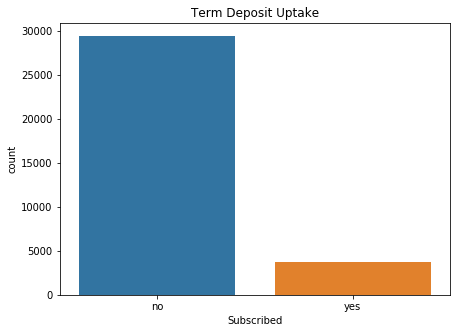

In [17]:
# Plot distribution of y
plt.figure(figsize = (7,5))
sns.countplot(df['y'])
plt.xlabel('Subscribed')
plt.title('Term Deposit Uptake')
plt.show()

In [18]:
# Get normalized value counts
df['y'].value_counts(normalize = True)

no     0.887339
yes    0.112661
Name: y, dtype: float64

We immediately notice that we are dealing with imbalanced classes, with 88% of the entries representing data for a customer who did not subscribe to the term deposit.

We will need to account for this imbalance or our model may be biased towards the majority class. We will also need to carefully select our evaluation metric to based on the business scenario. 

<font size="4"><b>Features

Let's investigate our features. We have a mix of numerical and categorical features to examine.

We begin by visualising numerical attributes via histograms.

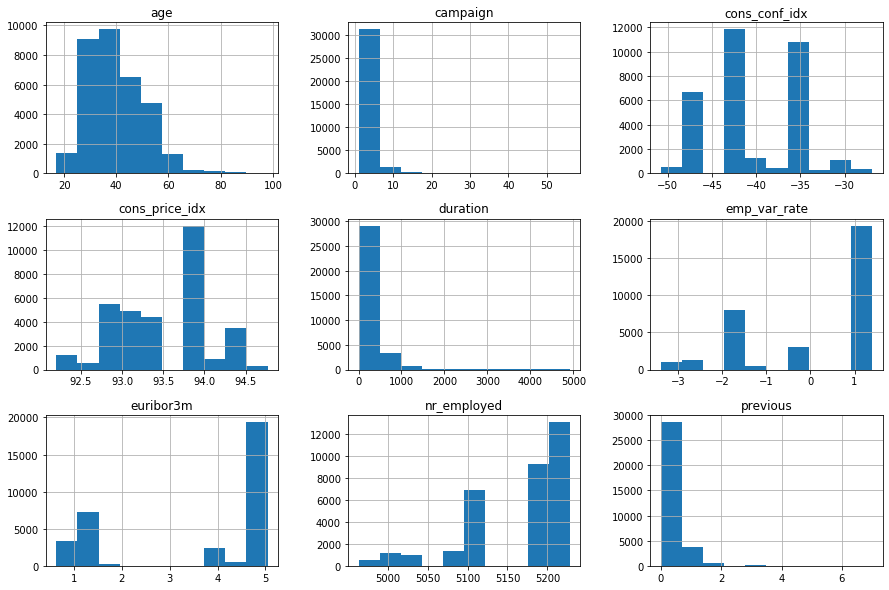

In [19]:
# Plot histograms
df.hist(figsize = (15,10))
plt.show()

<b>Let us visualize categorical attributes using barplots. We will distinguish between "yes" or "no" values of our target variable to get an initial idea of which attributes might have the biggest impact on whether a customer will subscribe to a term deposit.

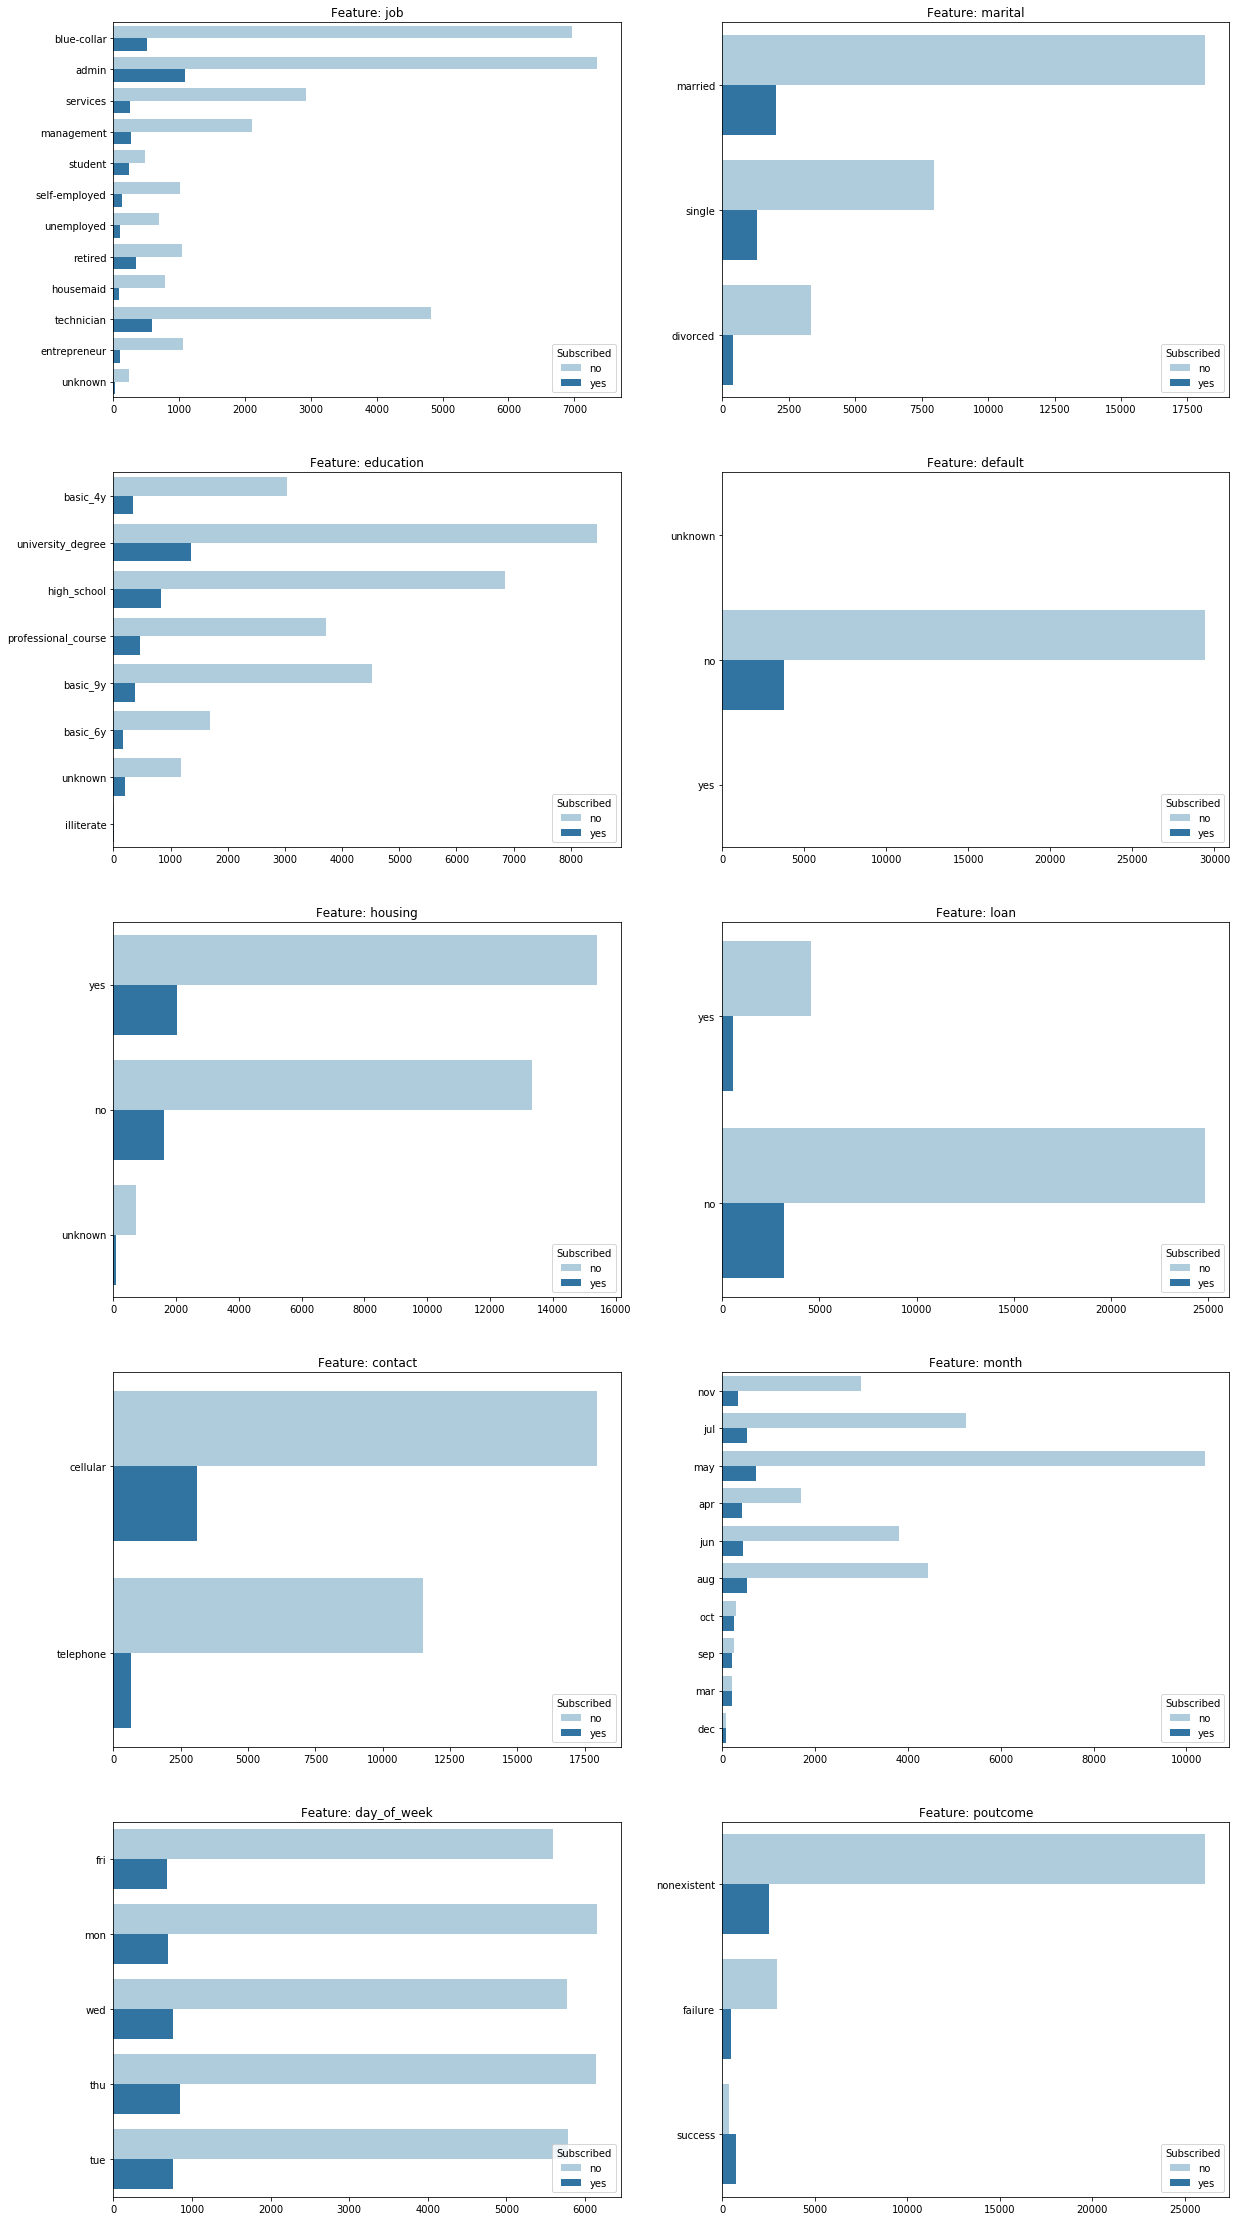

In [20]:
# Define cat feats as catcols less last item y
cat_feats = list(cat_cols)[:-1]

# Create barplot of categorical features with hue target variable

fig, axes = plt.subplots(5,2, figsize = (20,40))

for c, col in enumerate(cat_feats):
    ax_x = c // 2
    ax_y = c % 2
    sns.countplot(y = df[col], orient = 'h', hue = df['y'], palette = chosen_palette, ax = axes[ax_x, ax_y])
    
    axes[ax_x, ax_y].set_title(f'Feature: {col}')
    axes[ax_x, ax_y].set_ylabel(None) 
    axes[ax_x, ax_y].set_xlabel(None) 
    axes[ax_x, ax_y].legend(title = "Subscribed", loc = 'lower right') 
plt.show()

Due to the class imbalance, it is difficult to see which attributes have the highest impact on the target variable.

For instance, when looking at job, we just see fewer yes observations for every type of job.

Let us try and improve on this, by looking at the rate of subscribers for each job category. Once we have a more useful visualization, we will extend to the other categorical variables.

In [21]:
# Establish counts of subscribers based on job using grouby
counts = df[['job', 'y']].groupby(['job','y']).size().unstack()
counts

y,no,yes
job,,
admin,7339,1083
blue-collar,6969,514
entrepreneur,1061,104
housemaid,790,87
management,2100,270
retired,1035,345
self-employed,1005,123
services,2918,257
student,477,232


In [22]:
# Count number of observations for each job category
job_counts = counts.sum(axis = 'columns')
job_counts

job
admin            8422
blue-collar      7483
entrepreneur     1165
housemaid         877
management       2370
retired          1380
self-employed    1128
services         3175
student           709
technician       5412
unemployed        796
unknown           271
dtype: int64

In [23]:
# Obtain proportions by dividing by the respective job counts
job_props = counts.div(job_counts, axis = 'index')
job_props

y,no,yes
job,,
admin,0.871408,0.128592
blue-collar,0.931311,0.068689
entrepreneur,0.910730,0.089270
housemaid,0.900798,0.099202
management,0.886076,0.113924
retired,0.750000,0.250000
self-employed,0.890957,0.109043
services,0.919055,0.080945
student,0.672779,0.327221


Now that the yes or no subscription rates for each education level add up to 1, we can see that customers who are students or retired are most likely to subscribe to a term deposit.

We can visualize this clearly with a stacked bar chart.

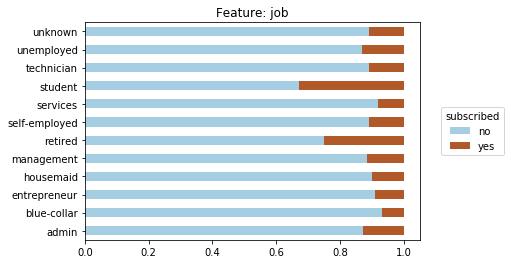

In [24]:
# Plot stacked bar chart
job_props.plot.barh(stacked = True, colormap = chosen_palette)
# Have legend to the side
plt.legend(
    loc = 'center left',
    bbox_to_anchor = (1.05,0.5),
    title = 'subscribed')
plt.title('Feature: job')
plt.ylabel(None)
plt.show()

<b>Let us define a function to create this plot, so that we can then easily apply it to the other features

In [25]:
# Define function for stacked barplot

def feature_rate_plot(col, target, df, colormap = chosen_palette, ax = None):
    '''
    Plots a stacked bar chart showing the rate of target class 1 for a specific feature.
    Args:
        col: feature column
        target: label column
        df: Pandas DataFrame
        colormap: choice of colormap, default is viridis
        ax: axes on which to plot, default is none
    Returns:
        None
    '''
    
    counts = df[[col, target]].groupby([col,target]).size().unstack()
    col_counts = counts.sum(axis = 'columns')
    col_props = counts.div(col_counts, axis = 'index')
    
    # Plot stacked bar chart
    col_props.plot.barh(stacked = True, colormap = colormap, ax = ax )
    
    if ax == None:
        plt.title(f'Feature: {col}')
        plt.legend(
            loc = 'center left',
            bbox_to_anchor = (1.05,0.5),
            title = 'subscribed')
        plt.ylabel(None)
        
    else:
        ax.set_title(f'Feature: {col}')
        ax.legend().remove()
        ax.set_ylabel(None)
        
    return None

<b>Let us apply this function to create stacked barplots of all categorical features highlighting the rate of subscription.

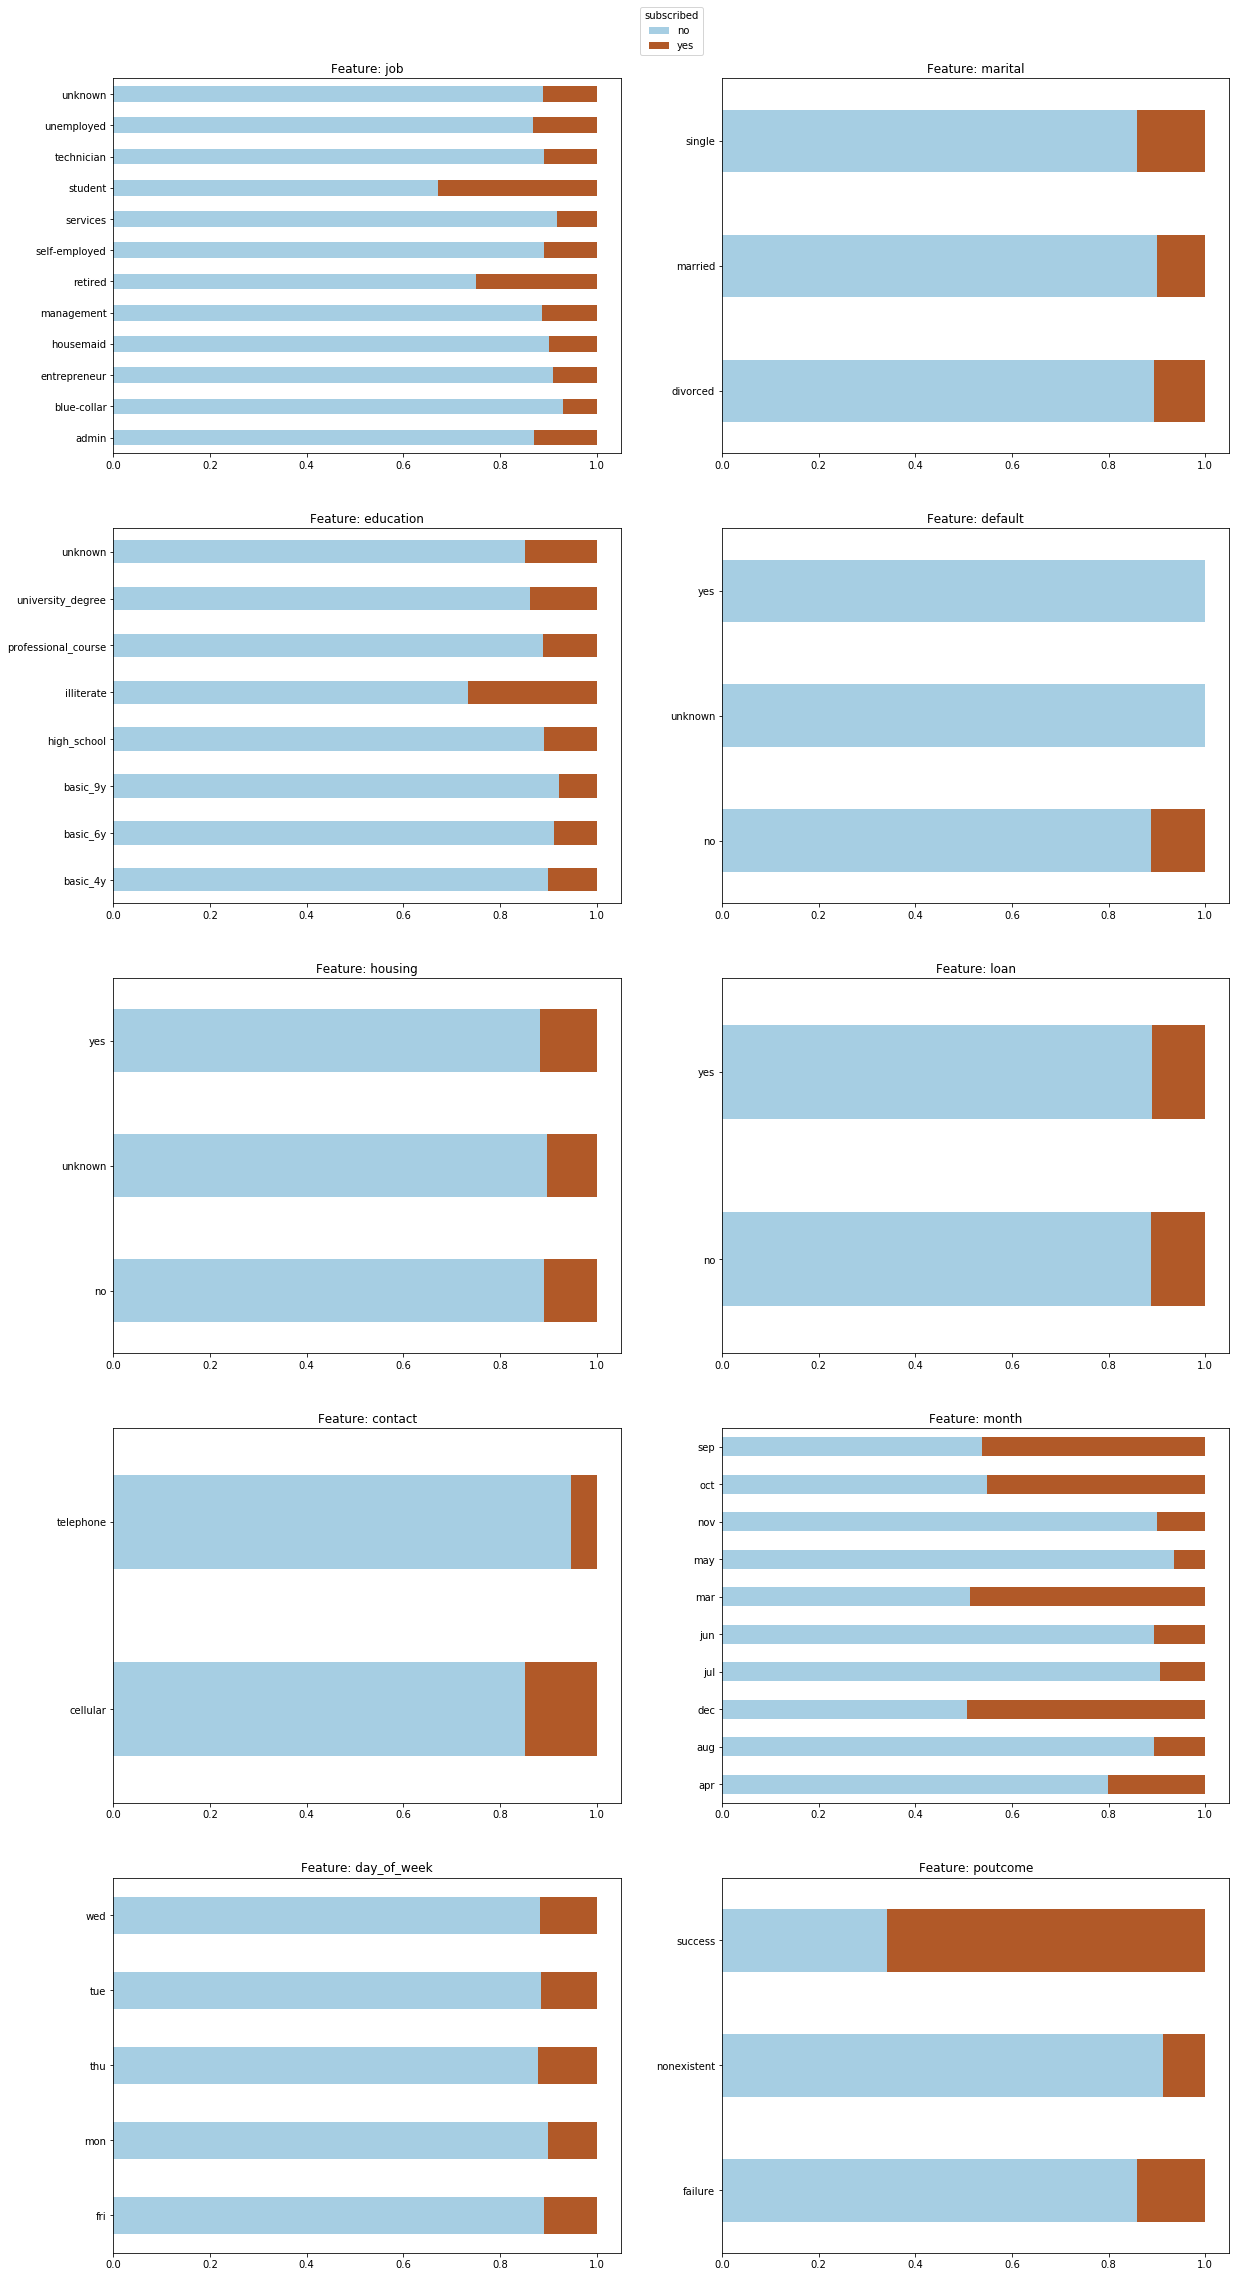

In [26]:
# Create barplot of categorical features with target variable rate

fig, axes = plt.subplots(5,2, figsize = (20,40))

for c, col in enumerate(cat_feats):
    ax_x = c // 2
    ax_y = c % 2
    feature_rate_plot(col, 'y', df, colormap = 'Paired', ax = axes[ax_x, ax_y] )
    
axes[0, 0].legend(
    loc='lower center', bbox_to_anchor=(1.1, 1.05), title='subscribed'
)
plt.savefig('Images/catydist.pdf')
plt.show()

<b>Analysis

From the visualisations, we can see that poutcome looks to be a good predictor, with customers who previously subscribed to a term deposit likely to do so again. Out of customers who subscribed last time (poutcome has value success) 65% subscribed again.

Also students and retired customers are more likely to subscribe to a term deposit. This is in line with expectations as they are less likely to need the funds for emergencies and able to manage their outgoings effectively.

<font size="4"><b>Analysis of Duration and Campaign Features

From the data dictionary we note that duration represents the last contact duration, in seconds (numeric).
This attribute highly affects the output target (as if duration=0 then the customer definitely did not subscribe to the term deposit and y is no). Moreover, the duration is not known before a call is performed and after the end of the call y is obviously known. Therefore we will examine this variable here but discard it when building a realistic predictive model.

In [27]:
# Describe duration feature
df['duration'].describe()

count    33188.000000
mean       258.842684
std        261.416735
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

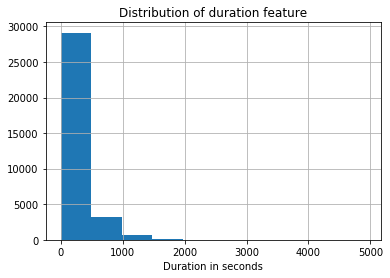

In [28]:
# Plot distribution of duration feature
df['duration'].hist()
plt.title('Distribution of duration feature')
plt.xlabel('Duration in seconds')
plt.show()

In [29]:
# Define categorical attribute which maps duration to above and below average
df['duration_category'] = df['duration'].map(lambda x: 'above average' if x > df['duration'].mean() \
                                        else 'below average')

<b>We can visualise this attribute using our previously defined feature_rate_plot function.

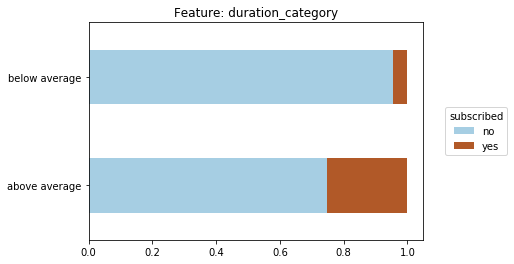

In [30]:
# Plot stacked bar chart (call duration_category and y in the df)
feature_rate_plot('duration_category', 'y', df) 

<b>Let us now focus on customers which did subscribe to the term deposit (target variable y is yes) and look to analyse the call duration.

In [31]:
# Describe duration feature where target variable is yes
df[df['y'] == 'yes']['duration'].describe()

count    3739.000000
mean      555.309976
std       407.505637
min        37.000000
25%       253.000000
50%       447.000000
75%       746.000000
max      4199.000000
Name: duration, dtype: float64

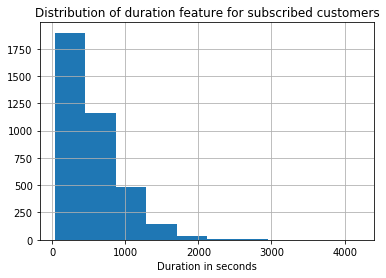

In [32]:
# Plot duration distribution where target variable is yes
df[df['y'] == 'yes']['duration'].hist()
plt.title('Distribution of duration feature for subscribed customers')
plt.xlabel('Duration in seconds')
plt.show()

<b>Analysis:

The mean call duration which resulted in a subscription is 553 seconds or just under 10 minutes.

In [33]:
# Describe duration feature where target variable is no
df[df['y'] == 'no']['duration'].describe()

count    29449.000000
mean       221.201637
std        208.230632
min          0.000000
25%         95.000000
50%        164.000000
75%        278.000000
max       4918.000000
Name: duration, dtype: float64

<b>Analysis:

On the other hand, the mean call duration which did not result in a subscription is 221 seconds or a bit less than 4 minutes.

<b>Let us know look at the campaign feature. It tells us the number of contacts performed during this campaign and for this client.

In [34]:
# Describe campaign feature
df['campaign'].describe()

count    33188.000000
mean         2.573008
std          2.781505
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

We see that on average, more than one call was made to each customer. The value of 56 is clearly an outlier and possibly an error. As we won't be keeping this feature for modelling purposes, we do not need to worry about it.

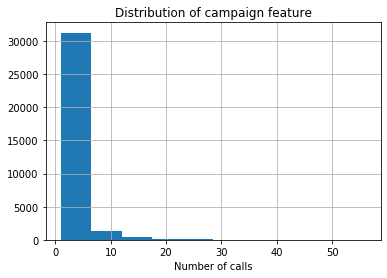

In [35]:
# Plot campaign distribution
df['campaign'].hist()
plt.title('Distribution of campaign feature')
plt.xlabel('Number of calls')
plt.show()

Let us now focus on customers which did subscribe to the term deposit (target variable y is yes) and look to analyse the campaign feature.

In [36]:
# Describe campaign feature where target variable is yes
df[df['y'] == 'yes']['campaign'].describe()

count    3739.000000
mean        2.052955
std         1.683292
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        23.000000
Name: campaign, dtype: float64

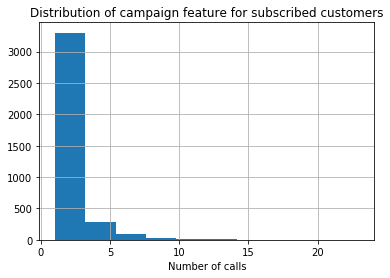

In [37]:
# Plot campaign distribution where target variable is yes
df[df['y'] == 'yes']['campaign'].hist()
plt.title('Distribution of campaign feature for subscribed customers')
plt.xlabel('Number of calls')
plt.show()

On average, it took two calls for customer to subscribe to a term deposit.

----

<font size="4"><b>Building a Customer Profile

In this section, our goal is to describe the profile of a typical customer who subscribed to the term deposit.

In [38]:
# Define dataframe of subscribers by taking taget value to be yes
subscribers = df[df['y']=='yes']

<b>How old are they?

In [39]:
# Use describe to get summary statistics
subscribers['age'].describe()

count    3739.000000
mean       40.849425
std        13.745141
min        17.000000
25%        31.000000
50%        37.000000
75%        49.000000
max        98.000000
Name: age, dtype: float64

We see that the mean age is 41.

<b>Let us split the data into categories.

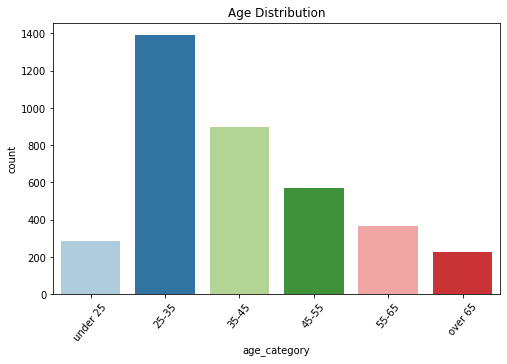

In [40]:
# Define bins based on statistics
age_cats = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['under 25', '25-35', '35-45', '45-55', '55-65', 'over 65']
    
# Map to bins using pd.cut()
subscribers['age_category'] = pd.cut(subscribers['age'], bins = age_cats, labels = age_labels)

# Plot job distribution amongst subscribers
plt.figure(figsize = (8,5))
sns.countplot(subscribers['age_category'], palette = chosen_palette)
plt.title("Age Distribution")
plt.xticks(rotation = 50)
plt.show()

We see that overall customers who subscribe tend to be in the 25-35 age range. Let us look at the rate of subscribers amongst the different age brackets.

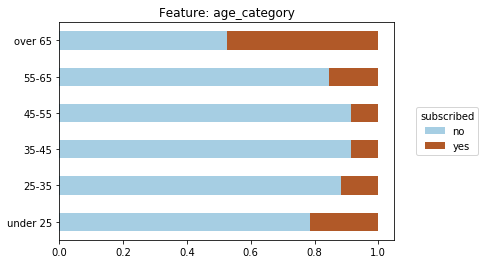

In [41]:
# Map to bins using pd.cut()
df['age_category'] = pd.cut(df['age'], bins = age_cats, labels = age_labels)

# Plot stacked bar chart
feature_rate_plot('age_category', 'y', df)

<b>Analysis:

It can be observed that those over 65 are far more likely to subscribe to a term deposit.

It would be recommended to focus on a targeted campaign for the over 65 demographic.

<b>What type of job do they tend to have?

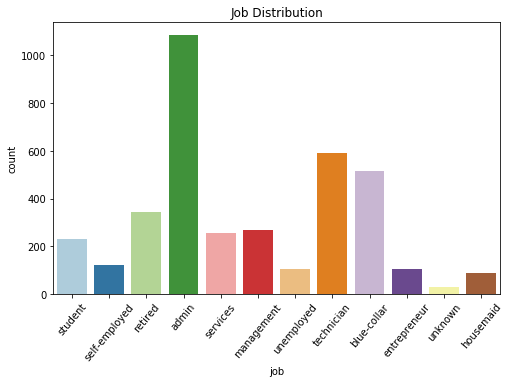

In [42]:
# Plot job distribution amongst subscribers
plt.figure(figsize = (8,5))
sns.countplot(subscribers['job'], palette = chosen_palette)
plt.title("Job Distribution")
plt.xticks(rotation = 50)
plt.show()

It can be observed that admin is by far the most popular category.

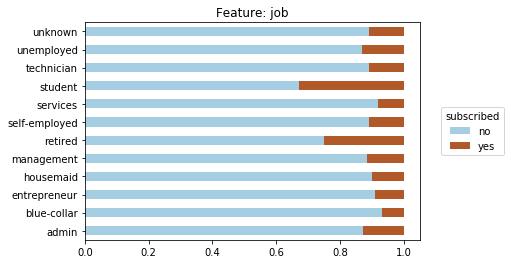

In [43]:
# Plot stacked bar chart
feature_rate_plot('job', 'y', df)
bbox_inches = "tight"

From the stacked bar chart, we see that retired and student customers have the greatest rate of subscription.

<b>Do they have a loan?

In [44]:
# Get normalized value counts for loan
subscribers['loan'].value_counts(normalize = True)

no     0.846483
yes    0.153517
Name: loan, dtype: float64

In [45]:
# Get normalized value counts for housing
subscribers['housing'].value_counts(normalize = True)

yes        0.543461
no         0.434876
unknown    0.021664
Name: housing, dtype: float64

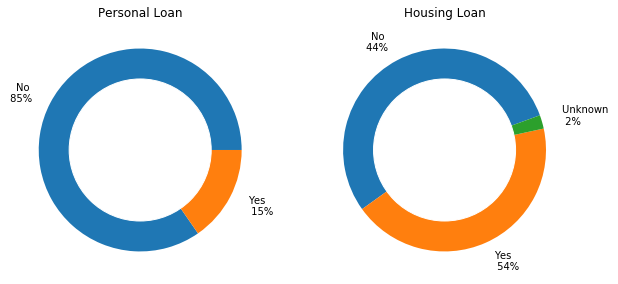

In [46]:
# Plot side by side donut chart for personal loan and housing loan
fig, axes = plt.subplots(1,2, figsize = (10,6), sharey = 'row')
axes[0].pie(subscribers['loan'].value_counts(), 
            labels = ['No \n 85%' , 'Yes \n 15%'], labeldistance=1.2)
axes[1].pie(subscribers['housing'].value_counts(), startangle=20, 
            labels = ['No \n 44%' , 'Yes \n 54%', 'Unknown \n 2%'], labeldistance=1.2)
for ax in axes:
    my_circle=plt.Circle((0,0), 0.7, color='white')
    p=plt.gcf()
    ax.add_artist(my_circle)
axes[0].set_title('Personal Loan')
axes[1].set_title('Housing Loan')
plt.show()

We see that customers who subscribed to a term deposit are unlikely to have a personal loan. They may however have a housing loan.

<b>How were they contacted?

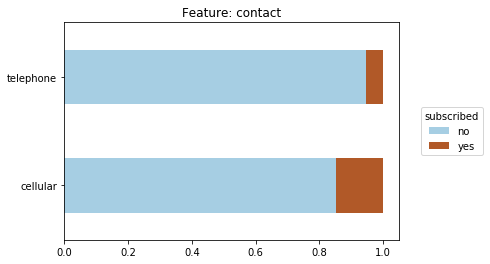

In [47]:
# Plot stacked bar chart
feature_rate_plot('contact', 'y', df)
bbox_inches = "tight"

We see that calls made to a cellular phone were more likely to result in a subscription.

It is therefore recommended to ficus on the cellular channel for future campaigns.

<b>When were they contacted (MONTH)?

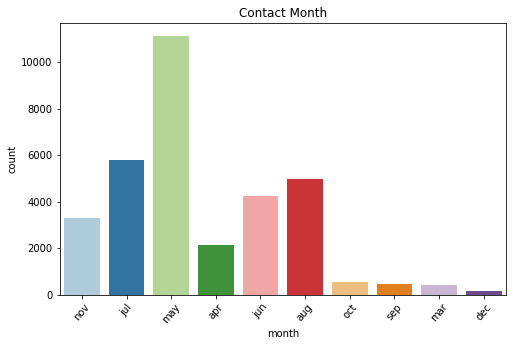

In [48]:
# Plot job distribution amongst subscribers
plt.figure(figsize = (8,5))
sns.countplot(df['month'], palette = chosen_palette)
plt.title("Contact Month")
plt.xticks(rotation = 50)
plt.show()

In [49]:
# Establish counts of subscribers based on month using grouby
countmonth = df[['month', 'y']].groupby(['month','y']).size().unstack()
countmonth

y,no,yes
month,,
apr,1704,429
aug,4439,528
dec,74,72
jul,5262,538
jun,3805,450
mar,219,208
may,10405,718
nov,2987,331
oct,306,252


In [50]:
# Count number of observations for each job category
month_counts = countmonth.sum(axis = 'columns')
month_counts

month
apr     2133
aug     4967
dec      146
jul     5800
jun     4255
mar      427
may    11123
nov     3318
oct      558
sep      461
dtype: int64

In [51]:
# Obtain proportions by dividing by the respective month counts
month_props = countmonth.div(month_counts, axis = 'index')
month_props

y,no,yes
month,,
apr,0.798875,0.201125
aug,0.893698,0.106302
dec,0.506849,0.493151
jul,0.907241,0.092759
jun,0.894242,0.105758
mar,0.512881,0.487119
may,0.935449,0.064551
nov,0.900241,0.099759
oct,0.548387,0.451613


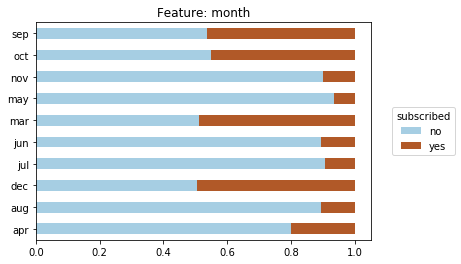

In [52]:
# Plot stacked bar chart
month_props.plot.barh(stacked = True, colormap = chosen_palette)
# Have legend to the side
plt.legend(
    loc = 'center left',
    bbox_to_anchor = (1.05,0.5),
    title = 'subscribed')
plt.title('Feature: month')
plt.ylabel(None)
plt.show()

<b>When were they contacted (DAY OF WEEK)?

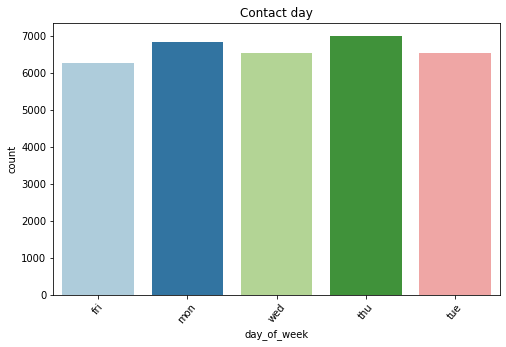

In [53]:
# Plot contact day distribution 
plt.figure(figsize = (8,5))
sns.countplot(df['day_of_week'], palette = chosen_palette)
plt.title("Contact day")
plt.xticks(rotation = 50)
plt.show()

In [54]:
# Establish counts of subscribers based on month using grouby
countday = df[['day_of_week', 'y']].groupby(['day_of_week','y']).size().unstack()
countday

y,no,yes
day_of_week,,
fri,5595,680
mon,6149,692
thu,6148,852
tue,5784,752
wed,5773,763


In [55]:
# Count number of observations for each day of the week
day_counts = countday.sum(axis = 'columns')
day_counts

day_of_week
fri    6275
mon    6841
thu    7000
tue    6536
wed    6536
dtype: int64

In [56]:
# Obtain proportions by dividing by the respective month counts
day_props = countday.div(day_counts, axis = 'index')
day_props

y,no,yes
day_of_week,,
fri,0.891633,0.108367
mon,0.898845,0.101155
thu,0.878286,0.121714
tue,0.884945,0.115055
wed,0.883262,0.116738


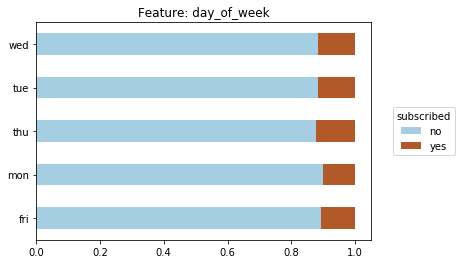

In [57]:
# Plot stacked bar chart
day_props.plot.barh(stacked = True, colormap = chosen_palette)
# Have legend to the side
plt.legend(
    loc = 'center left',
    bbox_to_anchor = (1.05,0.5),
    title = 'subscribed')
plt.title('Feature: day_of_week')
plt.ylabel(None)
plt.show()

-------------------------

<font size="4"><b>Investigate Correlations

Let us explore correlations between the numerical features.

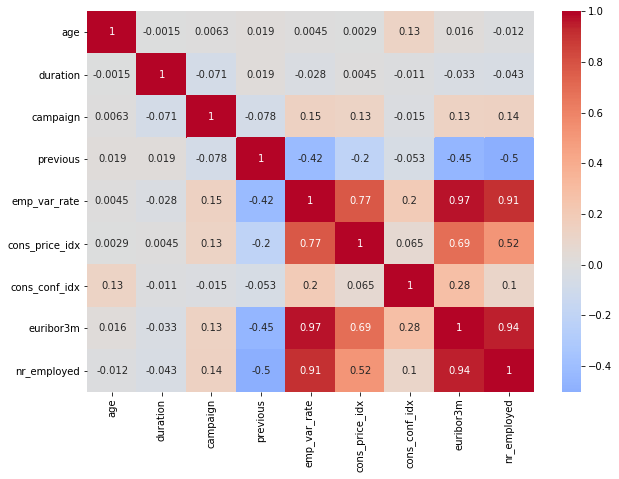

In [58]:
# Get correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize = (10,7))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

<b>Analysis

As expected, there is a high correlation amongst the economic features, namely cons_price_idx, euribor3m, emp_var_rate and nr_employed.

We will choose to keep all these features for now, but note that this may violate some of the algorithm assumptions. For example the Naive Bayes algorithm assumes that the features are independent. Keep this in mind when conducting Uplift Modeling.

---------

<font size="5"><b>Prepare Data for Modelling

Let us split into features X and target "y".

In [59]:
# Reset df index
df = df.reset_index(drop = True)

# Split into features X/ target y
X = df.drop('y', axis = 1)
y = df['y'].copy()

In [60]:
# Map y values to 1 and 0 
y = y.map(lambda x: 1 if x == 'yes' else 0)
y.value_counts()

0    29449
1     3739
Name: y, dtype: int64

<b> As discussed, we also have to drop the features duration and campaign as these would not be known prior to knowing the outcome of the target variable.

In [61]:
# Drop duration and campaign features
X = X.drop(['duration', 'duration_category', 'age_category', 'campaign'], axis = 1)


<font size="4"><b>Feature Scaling

Let's use sklearn's StandardScaler to normalize the data. Note that this is not required for all algorithms, but if we don't, this would have a negative impact on classifiers which rely on 'distance' such as K-Nearest Neighbours.

In [62]:
# Get data of numerical type
X_num = X.select_dtypes(include = np.number)

# Get data of categorical type
X_cat = X.select_dtypes(include = object)

# Instantiate Class
ss = StandardScaler()

# Fit and Transform Data
X_num_scaled = ss.fit_transform(X_num)

# Recreate DataFrame
X_num_scaled = pd.DataFrame(X_num_scaled, columns = X_num.columns)
X_num_scaled.head()

,age,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,1.248967,-0.35091,-0.116104,-0.650254,-0.321629,0.230744,0.398500
1,1.056542,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
2,-0.579069,-0.35091,0.648838,0.723131,0.890699,0.712385,0.332017
3,-0.098007,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
4,-1.060131,1.67554,-1.199773,-1.181273,-1.230875,-1.319160,-0.940853


Let's recreate our DataFrame by combining the scaled numerical attributes and categorical attributes.

In [63]:
# Combine X_num_scaled and categorical feats using pd.concat
X = pd.concat([X_num_scaled, X_cat], axis = 1)
X.head()

,age,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,1.248967,-0.35091,-0.116104,-0.650254,-0.321629,0.230744,0.398500,blue-collar,married,basic_4y,unknown,yes,yes,cellular,nov,fri,nonexistent
1,1.056542,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874,admin,married,university_degree,no,no,no,cellular,jul,mon,nonexistent
2,-0.579069,-0.35091,0.648838,0.723131,0.890699,0.712385,0.332017,services,married,high_school,no,no,no,telephone,may,wed,nonexistent
3,-0.098007,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874,admin,single,high_school,no,yes,no,cellular,jul,fri,nonexistent
4,-1.060131,1.67554,-1.199773,-1.181273,-1.230875,-1.319160,-0.940853,admin,single,university_degree,no,yes,no,cellular,may,wed,failure


<font size="4"><b>Categorical Feature Imputing

As mentioned in the section 3. we will replace the unknown values in certain categorical columns using the K-Nearest Neighbors imputer. This is for columns where there was no dominating value and so the mode was not deemed to be appropriate.

There will be three steps to this process.

    1) Convert non-missing categorical features to ordinal values and create an ordinal DataFrame
    2) Impute the missing values in the ordinal DataFrame
    3) Convert the ordinal DataFrame back to original categorical values.


In [64]:
# Define categorical columns
cat_cols = X.select_dtypes(include = object).columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [65]:
# Define feats where unknown will be replaced
cols = ['job', 'education', 'housing']

# Replace unknown with np.nan
for col in cols:
    X[col] = X[col].replace('unknown', np.nan)

# Check missing values introduced
X.isna().any()

age               False
previous          False
emp_var_rate      False
cons_price_idx    False
cons_conf_idx     False
euribor3m         False
nr_employed       False
job                True
marital           False
education          True
default           False
housing            True
loan              False
contact           False
month             False
day_of_week       False
poutcome          False
dtype: bool

In [66]:
# Adapted from Datacamp advanced imputation techniques
# https://campus.datacamp.com/courses/dealing-with-missing-data-in-python/advanced-imputation-techniques?ex=7

# Create dictionary for Ordinal encoders
ordinal_enc_dict = {}

# Loop over categorical columns
for col_name in cat_cols:
    
    # Create ordinal encoder instance
    ordinal_enc_dict[col_name] = OrdinalEncoder()
    
    # Select non-null values
    col = X[col_name]
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1,1)
    
    # Encode non-null values in column
    ordinal_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
    # Update non-null values in X with encoded values
    X.loc[col.notnull(), col_name] = np.squeeze(ordinal_vals)

# Check ordinal encoding 
X.head()

,age,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,1.248967,-0.35091,-0.116104,-0.650254,-0.321629,0.230744,0.398500,1,1.0,0,1.0,1,1.0,0.0,7.0,0.0,1.0
1,1.056542,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874,0,1.0,6,0.0,0,0.0,0.0,3.0,1.0,1.0
2,-0.579069,-0.35091,0.648838,0.723131,0.890699,0.712385,0.332017,7,1.0,3,0.0,0,0.0,1.0,6.0,4.0,1.0
3,-0.098007,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874,0,2.0,3,0.0,1,0.0,0.0,3.0,0.0,1.0
4,-1.060131,1.67554,-1.199773,-1.181273,-1.230875,-1.319160,-0.940853,0,2.0,6,0.0,1,0.0,0.0,6.0,4.0,0.0


----------------

Now that we have performed step 1, ordinal encoding, we can proceed to step 2, imputation.

In [67]:
# Adapted from Datacamp advanced imputation techniques
# https://campus.datacamp.com/courses/dealing-with-missing-data-in-python/advanced-imputation-techniques?ex=7

# Create copy of X
X_imputed = X.copy(deep = True)

# Create imputer instance
knn_imputer = KNNImputer()

# Apply imputer
X_imputed.iloc[:,:] = knn_imputer.fit_transform(X_imputed)

# Check
X_imputed.isna().any().any()

False

Finally as step 3, we reverse the ordinal values back to categorical values.

In [68]:
# Reverse to get back to categorical values
for col_name in cat_cols:
    
    # Reshape 
    reshaped_col = X_imputed[col_name].values.reshape(-1,1)
    #
    X_imputed[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped_col)
    
# Check DataFrame
X_imputed.head()

,age,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,1.248967,-0.35091,-0.116104,-0.650254,-0.321629,0.230744,0.398500,blue-collar,married,basic_4y,unknown,yes,yes,cellular,nov,fri,nonexistent
1,1.056542,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874,admin,married,university_degree,no,no,no,cellular,jul,mon,nonexistent
2,-0.579069,-0.35091,0.648838,0.723131,0.890699,0.712385,0.332017,services,married,high_school,no,no,no,telephone,may,wed,nonexistent
3,-0.098007,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874,admin,single,high_school,no,yes,no,cellular,jul,fri,nonexistent
4,-1.060131,1.67554,-1.199773,-1.181273,-1.230875,-1.319160,-0.940853,admin,single,university_degree,no,yes,no,cellular,may,wed,failure


In [69]:
X_imputed.to_csv('bankimputed.csv')

------------

<font size="4"><b>Categorical Feature Encoding

Let's use sklearn's OneHotEncoder to encode categorical variables.

In [70]:
# Get data of type object
X_cat = X_imputed.select_dtypes(include = object)

# Instantiate Class
ohe = OneHotEncoder()

# Fit and transform 
X_cat_1hot = ohe.fit_transform(X_cat)

# View results
X_cat_1hot

<33188x48 sparse matrix of type '<class 'numpy.float64'>'
	with 331880 stored elements in Compressed Sparse Row format>

<b> OneHotEncoder creates a sparse matrix, which is useful for memory purposes when dealing with large datasets and significantly more columns. However we will transform back into a Numpy array and then DataFrame.

In [71]:
# Get column names
column_names = ohe.get_feature_names(X_cat.columns)

# Recreate dataframe
X_cat_encoded = pd.DataFrame(X_cat_1hot.toarray(), columns = column_names)

X_cat_encoded.head()

,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


We can now combine the above DataFrame with the numerical features in X_imputed to get our final prepared DataFrame.

In [72]:
# Combine numerical feats of X_imputed with X_cat_encoded using pd.concat
X_prepared = pd.concat([X_cat_encoded, X_imputed.select_dtypes(include = np.number)], axis = 1)
X_prepared.head()

,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_failure,poutcome_nonexistent,poutcome_success,age,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.248967,-0.35091,-0.116104,-0.650254,-0.321629,0.230744,0.398500
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.056542,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-0.579069,-0.35091,0.648838,0.723131,0.890699,0.712385,0.332017
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.098007,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.060131,1.67554,-1.199773,-1.181273,-1.230875,-1.319160,-0.940853


In [73]:
# Check shape
X_prepared.shape

(33188, 55)

<font size="4"><b>Creating Pre-processing Classes

We will begin by creating a class to do the syntax clean up and dropping unecessary features, namely removing special characters from the column names or values and removing duration, campaign and pdays. We will also add methods to retrieve the cleaned column names.

In [74]:
# Define SyntaxCleaner class
# Inherit from BaseEstimator and TransformerMixin

class SyntaxCleanandDrop(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        # Remove special characters for column names
        specialchars = "()*&^@#$%."
        for char in specialchars:
            X.columns = X.columns.str.replace(char, '_')
        
        # Replace "." in job feat by " " as end of string
        X['job'] = X['job'].str.replace('.','')
        
        # Replace "." in education feat with "_"
        X['education'] = X['education'].str.replace('.', '_')
        
        # Drop duration, campaign and pdays
        X = X.drop(['duration', 'campaign', 'pdays'], axis = 1)
        
        # Assign num column names
        self.num_feat_names = list(X.select_dtypes(include = np.number).columns)
        
        # Assign cat column names
        self.cat_feat_names = list(X.select_dtypes(include = object).columns)
        
        return X
    
    def get_num_feat_names(self):
        return self.num_feat_names
    
    def get_cat_feat_names(self):
        return self.cat_feat_names


Our next class will be for pre-processing numerical features. Whilst we could use sklearn's in built in functions, having our custom class makes it easier to return a DataFrame.


In [75]:
class NumPreprocess (BaseEstimator, TransformerMixin):
        
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Get data of numerical type
        X_num = X.select_dtypes(include = np.number).reset_index(drop = True)
        
         # Get data of categorical type
        X_cat = X.select_dtypes(include = object).reset_index(drop = True)
        
        # Fill missing values with median if any
        for col in X_num.columns:
            X_num[col] = X_num[col].fillna(X_num[col].median())
            
        # Scale using standard scaler
        ss = StandardScaler()
        
        # Fit and Transform Data
        X_num_scaled = ss.fit_transform(X_num)
        
        # Recreate DataFrame
        X_num_scaled = pd.DataFrame(X_num_scaled, columns = X_num.columns)
        
        # Combine X_num_scaled and categorical feats using pd.concat
        X = pd.concat([X_num_scaled, X_cat], axis = 1)
        
        return X 

Our final class will be specifically for imputing the unknown values in categorical features using K-Nearest Neighbors.

In [76]:
# Define UnknownImputer class
# Inherit from BaseEstimator and TransformerMixin

class UnknownImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        # Define categorical columns
        cat_cols = X.select_dtypes(include = object).columns
        
        # Replace unknown will np.nan
        for col in cat_cols:
            X[col] = X[col].replace('unknown', np.nan)
            
        # Create dictionary for Ordinal encoders
        ordinal_enc_dict = {}

        # Loop over categorical columns
        for col_name in cat_cols:
    
            # Create ordinal encoder instance
            ordinal_enc_dict[col_name] = OrdinalEncoder()
    
            # Select non-null values
            col = X[col_name]
            col_not_null = col[col.notnull()]
            reshaped_vals = col_not_null.values.reshape(-1,1)
    
            # Encode non-null values in column
            ordinal_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
            # Update non-null values in X with encoded values
            X.loc[col.notnull(), col_name] = np.squeeze(ordinal_vals)
            
        # Create copy of X
        X_imputed = X.copy(deep = True)

        # Create imputer instance
        knn_imputer = KNNImputer()

        # Apply imputer
        X_imputed.iloc[:,:] = knn_imputer.fit_transform(X_imputed)

        # Reverse to get back to categorical values
        # Select original categorical column names 
        for col_name in cat_cols:
            reshaped_col = X_imputed[col_name].values.reshape(-1,1)
            X_imputed[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped_col)
            
        return X_imputed

<font size="4"><b>Pre-processing Pipeline

We can use ColumnTransformer to apply different processing functions to a specific set of columns. Let's create one to apply one-hot encoding to the categorical variables.

In [77]:
# Define categorical attributes
cat_attribs = ['job', 'marital','education', 'default', 'housing', 'loan', 'contact', 'month', \
               'day_of_week', 'poutcome']

cat_process = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_attribs)],
    remainder = 'passthrough')

We combine the ColumnTransformer above with the custom classes defined previously to create our pre-processing pipeline.

In [78]:
# Define pipeline

preproc_pipeline = Pipeline(steps =[
        ('syntaxclean', SyntaxCleanandDrop()),
        ('numprocess', NumPreprocess()),
        ('unknownimputer', UnknownImputer()),
        ('catprocess', cat_process)
])

<b>Let us check our pipeline by applying it to a 'fresh' copy of the training set.

In [79]:
# Create copy
df_copy = train_set.reset_index(drop = True)

# Define y
y = df_copy['y']

# Map y values to 1 and 0 
y = y.map(lambda x: 1 if x == 'yes' else 0)

# Define X
X = df_copy.drop('y', axis = 1)
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,53,blue-collar,married,basic.4y,unknown,yes,yes,cellular,nov,fri,98,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8
1,51,admin.,married,university.degree,no,no,no,cellular,jul,mon,455,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
2,34,services,married,high.school,no,no,no,telephone,may,wed,122,5,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
3,39,admin.,single,high.school,no,yes,no,cellular,jul,fri,361,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
4,29,admin.,single,university.degree,no,yes,no,cellular,may,wed,215,3,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1


In [80]:
# Apply pipeline
X_prepared = preproc_pipeline.fit_transform(X)
X_prepared

array([[ 0.        ,  1.        ,  0.        , ..., -0.32162899,
         0.23074365,  0.39849963],
       [ 1.        ,  0.        ,  0.        , ..., -0.47316998,
         0.77352724,  0.84587382],
       [ 0.        ,  0.        ,  0.        , ...,  0.89069896,
         0.71238478,  0.33201678],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.89069896,
         0.71353841,  0.33201678],
       [ 1.        ,  0.        ,  0.        , ...,  0.9556451 ,
         0.77410406,  0.84587382],
       [ 0.        ,  0.        ,  0.        , ...,  2.31951403,
        -1.63410157, -2.07106127]])

<b>To check, let us get the column names and recreate a DataFrame.

In [81]:
# Get cleaned numerical column names
num_cleaned_attribs = preproc_pipeline['syntaxclean'].get_num_feat_names()

# Get one hot encoded column names
ohe_attribs = preproc_pipeline['catprocess'].transformers_[0][1].get_feature_names(cat_attribs)

# List of all columns 
attribs = list(ohe_attribs) + num_cleaned_attribs

# Show prepared df
X_prepared_df = pd.DataFrame(X_prepared, columns = attribs)
X_prepared_df.head()

,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_failure,poutcome_nonexistent,poutcome_success,age,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.248967,-0.35091,-0.116104,-0.650254,-0.321629,0.230744,0.398500
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.056542,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-0.579069,-0.35091,0.648838,0.723131,0.890699,0.712385,0.332017
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.098007,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.060131,1.67554,-1.199773,-1.181273,-1.230875,-1.319160,-0.940853


In [82]:
# Convert to CSV
X_prepared_df.to_csv('data/X_train_prepared.csv')

-------------------

<font size="6"><b>Modelling

With preprocessing completed we are now ready to build a machine learning model to predict subscribers.

<font size="4"><b>Create Evaluation Test Set

In [83]:
# Read prepared DF and check loaded
X = pd.read_csv('data/X_train_prepared.csv', index_col = 0)
X.head()

,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_failure,poutcome_nonexistent,poutcome_success,age,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.248967,-0.35091,-0.116104,-0.650254,-0.321629,0.230744,0.398500
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.056542,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-0.579069,-0.35091,0.648838,0.723131,0.890699,0.712385,0.332017
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.098007,-0.35091,0.840074,0.591673,-0.473170,0.773527,0.845874
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.060131,1.67554,-1.199773,-1.181273,-1.230875,-1.319160,-0.940853


For this train-test split, we will choose to have a test size of 20% of the data. We will also use stratify to ensure the minority class is proportionally represented in our test set.

In [84]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, \
                                                    random_state = random_state)

-----------------------------

<font size="4"><b>Choice of Evaluation Metric

As we saw in the previous section, we are dealing with unbalanced target classes. The distribution of the target variable is reproduced below.

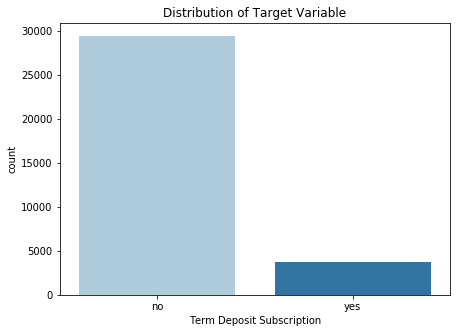

In [85]:
# Plot distribution of y
plt.figure(figsize = (7,5))
sns.countplot(df['y'], palette ='Paired')
plt.xlabel('Term Deposit Subscription')
plt.title('Distribution of Target Variable')
plt.show()

In [86]:
# Get normalized value counts
df['y'].value_counts(normalize = True)

no     0.887339
yes    0.112661
Name: y, dtype: float64

Let us look at various metrics and discuss whether or not they are suitable for our particular scenario.

We begin with a confusion matrix, which shows all possible outcomes.
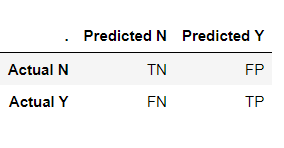

In our scenario, a false negative occurs when the model predicts that a customer will not subscribe (target no) when in fact they would have. This is hugely detrimental, as the bank would lose out on potential revenue. We estimate the revenue resulting from a subscription be valued at EUR 250. As such we need to ensure the false negatives predicted by our model are minimized.

On the other hand, a false positive occurs when the model predicts that a customer will subscribe (target yes) when in fact they won't. In this case, we have wasted the cost of a telephone call.

As such, false negatives are worse than false positives.

Let us now look at the metrics derrived from the values in the confusion matrix.

<b> Accuracy

Accuracy is the most straightforward metric defined simply as the number of correct predictions over the total number of observations.
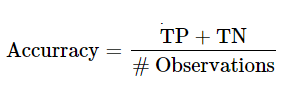

However consider a no skill model that simply predicts no for every customer. This model would achieve an accuracy score of 88% based on the imabalanced class distribution. As such high accuracy does not accurately describe a useful model for our purposes.

Moreover, even if we adjust for class imbalance, accuracy still attributes the same weighting to false positive and false negatives (i.e. wrong predictions). However we in our case False Negatives are a lot more detrimental.

<b>Precision

Precision determines out of true predictions, how many are actually true.
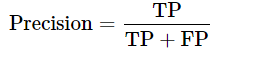

If we want high precision, we would attribute a greater importance to false positives, which is not the case. As such we should not focus on precision score as an evaluation metric.

<b>Recall

Recall out of true observations, how many were accurately predicted.
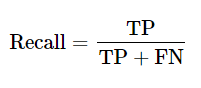

As discussed above, we want to minimize false negatives. As such recall is a useful metric we should seek a model with a high recall value.

-----------------

<font size="4"><b> Creating the appropriate metric for this problem
    

To create another metric specific to our problem, let us introduce a profit matrix, assigning values to possible outcomes.

A false positive has a cost associated to it, as we have wasted a call.
This is denoted by −C. On the other hand a true positive results in revenue minus the call cost, denoted by R−C.
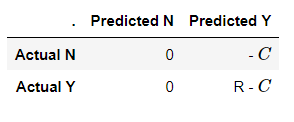

We can then define our profit metric as follows:
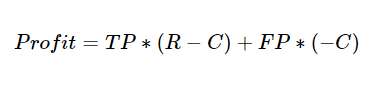

where we have:

- C cost of a call
- R expected revenue from a successful subscription

Based on domain knowledge, we assign values to C and R. In this project, we have been informed that stakeholders value a subscription at EUR 100. Similarly, the telemarketing calls have been assigned a cost of EUR 10 per call.

In [87]:
# Define calculate profit function
def calc_profit(y_true, y_pred, C = 10, R = 100):
    '''
    '''
    TP = confusion_matrix(y_true, y_pred)[1, 1]
    FP = confusion_matrix(y_true, y_pred)[0, 1]
    
    profit = TP*(R-C)+FP*(-C)
    
    return profit

<b> What would be the cost and revenue if we decided to contact all (8000) the new customers?

Whilst this is not applicable to the problem statement as we have a constraint on the number of call we can make, let us still see what the expected profit would be assuming the bank could contact all customers (i.e. predict y for all entries).

In [88]:
# Define arrays with 1s (predict yes)
y_test_pred = np.ones(len(y_test))
test_profit = calc_profit(y_test, y_test_pred)
print(f'Expected profit: €{test_profit}')

Expected profit: €8420


If we contacted all 8000 customers, we would expect to generate a revenue of €8420.

Finally, we note metrics which try and achieve a balance between precision and recall. As said above, recall remains our priority but nonetheless these metrics are worth investigating.

<b> Receiver Operating Characteristics (ROC) curve and associated AUC (Area under Curve) metric

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. We will use the Youden's J statistic to find the optimal point on the curve and threshold.

<b>F1 Threshold

The F1 threshold is weighted average of Precision and Recall of a model.

---------------------

<font size="4"><b>Dealing with Class Imbalance

We will try two methods to adjust for the class imabalance.

First we will investigate adjusting the weights to be inversely proportional to the frequency of the classes. With Sklearn, we can set the class_weight parameter to be balanced. This means that mistakes for the minority class will be more strongly penalized than mistakes for the majority class.

In [89]:
# Instantiate 
logreg = LogisticRegression(fit_intercept = True, C = 1e17, 
                            random_state = random_state, class_weight= 'balanced')

# Fit Model
logreg.fit(X_train, y_train)

# Get Predictions
train_preds = logreg.predict(X_train)
test_preds = logreg.predict(X_test)

print('Classification Report for Train set')
print(classification_report(y_train, train_preds))
print('Classification Report for Test set')
print(classification_report(y_test, test_preds))

Classification Report for Train set
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     23559
           1       0.36      0.63      0.45      2991

    accuracy                           0.83     26550
   macro avg       0.65      0.74      0.68     26550
weighted avg       0.88      0.83      0.85     26550

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      5890
           1       0.36      0.63      0.46       748

    accuracy                           0.83      6638
   macro avg       0.66      0.75      0.68      6638
weighted avg       0.88      0.83      0.85      6638



Now let us try using SMOTE (Synthetic Minority Oversampling Technique). This creates new synthetic data of the minority class.

In [90]:
# Create instance of SMOTE
smote = SMOTE(random_state = random_state)

# Apply smote
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

# Instantiate 
logreg = LogisticRegression(fit_intercept = True, C = 1e17, 
                            random_state = random_state)

# Fit Model
logreg.fit(X_train_resampled, y_train_resampled)

# Get Predictions
train_preds = logreg.predict(X_train_resampled)
test_preds = logreg.predict(X_test)

print('Classification Report for Train set')
print(classification_report(y_train_resampled, train_preds))
print('Classification Report for Test set')
print(classification_report(y_test, test_preds))

Classification Report for Train set
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     23559
           1       0.81      0.63      0.71     23559

    accuracy                           0.74     47118
   macro avg       0.75      0.74      0.74     47118
weighted avg       0.75      0.74      0.74     47118

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      5890
           1       0.35      0.64      0.46       748

    accuracy                           0.83      6638
   macro avg       0.65      0.75      0.68      6638
weighted avg       0.88      0.83      0.85      6638



Both methods have given good results, but we will choose to use SMOTE as it is more widely used and will work for non-parametric classifiers when we do not have the option to adjust class weights to balanced.

Going forward, we will therefore use X_train_resampled and y_train_resampled and be sure to incorporate SMOTE into our final pipeline.

In [91]:
# Define arrays with 1s (predict yes)
y_test_pred = np.ones(len(y_test))
test_profit = calc_profit(y_test, test_preds)
print(f'Expected profit - Test set: €{test_profit}')

Expected profit - Test set: €34270


------------------

<font size="4"><b>Baseline Model

As a starting point and baseline model, let us try logistic regression.

In [92]:
# Instantiate Logistic Regression
logreg = LogisticRegression(fit_intercept = True, C = 1e17, random_state = random_state)

# Fit classifier
logreg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1e+17, random_state=0)

In [93]:
# Get Predictions
train_preds = logreg.predict(X_train_resampled)
test_preds = logreg.predict(X_test)

print('Classification Report for Train set')
print(classification_report(y_train_resampled, train_preds))
print('Classification Report for Test set')
print(classification_report(y_test, test_preds))

Classification Report for Train set
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     23559
           1       0.81      0.63      0.71     23559

    accuracy                           0.74     47118
   macro avg       0.75      0.74      0.74     47118
weighted avg       0.75      0.74      0.74     47118

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      5890
           1       0.35      0.64      0.46       748

    accuracy                           0.83      6638
   macro avg       0.65      0.75      0.68      6638
weighted avg       0.88      0.83      0.85      6638



From the classification report, we see that the model does not appear to be overfitting and is a good starting point. Focussing on recall we see that the recall for the minority class (target 1) is similar for both training and testing sets (train recall = 0.63 and test recall = 0.62).

In [94]:
# Define function to plot confusion matrices

def CNF_plot(estimator, X_train, y_train, X_test, y_test):
    '''
    Plots side by side confusion matrix for train and test sets

    Args:
        estimator: estimator instance
        X_train: {array-like, sparse matrix} of shape (n_samples, n_features) train input values
        y_train: array-like of shape (n_samples,) train target values
        X_test: {array-like, sparse matrix} of shape (m_samples, m_features) test input values
        y_test: array-like of shape (m_samples,) test target values

    Returns:
        None
    '''
    fig, axes = plt.subplots(1,2, figsize = (10,6), sharey = 'row')
    plot_confusion_matrix(estimator, X_train, y_train, values_format = '.0f', ax = axes[0])
    axes[0].set_title('Training Set Confusion Matrix') 
    plot_confusion_matrix(estimator, X_test, y_test, values_format = '.0f', ax = axes[1])
    axes[1].set_title('Test Set Confusion Matrix')
    plt.show()  
    
    return None

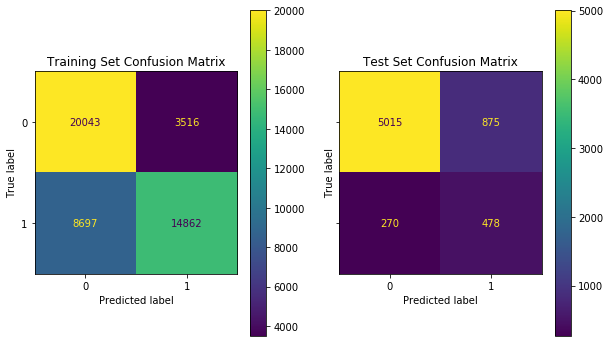

In [95]:
# Apply function
CNF_plot(logreg, X_train_resampled, y_train_resampled, X_test, y_test)

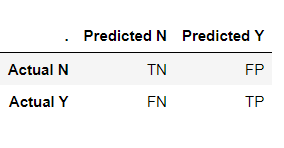
Note that in the training set, we have proportionally far more true positives that the test set as we have adjusted for the class imbalance using SMOTE.

In the test set, we do see that there are more false positives than false negatives, which is good but we want to see if we can still lower the number of false negatives.

Whilst the predict method above gave crisp label predictions, we now use the predict_proba method to get probability scores for class 1 (target yes). This will allow us to look at ROC/AUC metric as well as our custom profit calculation.

In [96]:
# Get probabilities
y_train_hat = logreg.fit(X_train_resampled, y_train_resampled).predict_proba(X_train_resampled)
# Take second column for class 1 probabilities
y_train_score = y_train_hat[:,1]

# Get probabilities
y_test_hat = logreg.fit(X_train_resampled, y_train_resampled).predict_proba(X_test)
# Take second column for class 1 probabilities
y_test_score = y_test_hat[:,1]

We now define a function to plot side by side ROC curves for train and test sets.

In [97]:
def ROC_plot(clf_name, y_train, y_test, y_train_score, y_test_score):
    '''
    Plots side by side ROC curves for train and test sets

    Args:
        clf_name: {string} name of estimator for display
        y_train: array-like of shape (n_samples,) train target values
        y_test: array-like of shape (m_samples,) test target values
        y_train_score: positive class probability predictions of train values
        y_test_score: positive class probability predictions of test values

    Returns:
        None
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_score)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_score)
    
    # Calculate best threshold using Youden's J statistic
    J_train = tpr_train - fpr_train
    ix_train = np.argmax(J_train)
    best_train_t = round(thresholds_train[ix_train],3)
    J_test = tpr_test - fpr_test
    ix_test = np.argmax(J_test)
    best_test_t = round(thresholds_test[ix_test],3)

    # Plot ROC side by side
    fig, axes = plt.subplots(1,2, figsize = (13,6))
    
    # Plot ROC curve for train set
    axes[0].plot(fpr_train, tpr_train, color='darkorange', lw=4, label= clf_name)
    # Add point for best threshold
    axes[0].scatter(fpr_train[ix_train], tpr_train[ix_train], marker='o', 
                zorder = 3, label=f'Best Threshold = {best_train_t:.2f}')
    # Plot ROC curve for test set
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=4, label= clf_name)
    # Add point for best threshold
    axes[1].scatter(fpr_test[ix_test], tpr_test[ix_test], marker='o', 
                zorder = 3, label=f'Best Threshold = {best_test_t:.2f}')
    
    # for both plots add no skill line, and ax labels
    for ax in axes:
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
    axes[0].set_title(f'ROC Curve - Training Set \n AUC = {round(auc(fpr_train, tpr_train),2)}')
    axes[1].set_title(f'ROC Curve - Test Set \n AUC = {round(auc(fpr_test, tpr_test),2)}')
    plt.show()
    
    return None

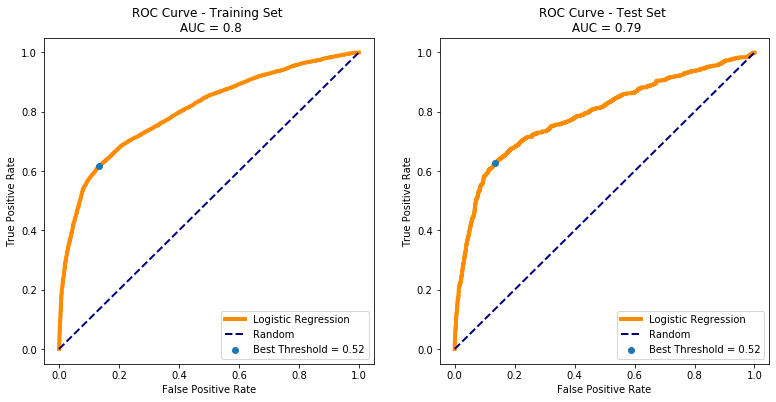

In [98]:
ROC_plot('Logistic Regression', y_train_resampled, y_test, y_train_score, y_test_score)

The AUC score for both is good, we will of course seek to improve with different classifiers but it is a decent starting point.


-----------------

Let us now define a function to determine the best threshold based on maximising the profit as defined in the previous section.

In [99]:
# Define function to map probability to label
def get_class(proba, threshold):
    '''Converts probability to class depending on threshold'''
    return (proba >= threshold).astype('int')


def profit_threshold_optimizer(y, y_score):
    '''
    Calculates optimal threshold to maximise profit 

    Args:
        y: array-like of shape (m_samples,) test target values
        y_score: positive class probability predictions of test values

    Returns:
        best_t: best threshold
        best_profit: highest profit
    '''
    # Define thresholds
    thresholds = np.arange(0,1,0.1)
    
    # Calculate profit for each threshold
    profits = []
    for t in thresholds:
        y_preds = get_class(y_score, t)
        profit = calc_profit(y, y_preds)
        profits.append(profit)
    
    # Get best threshold and best profit
    ix = np.argmax(profits)
    best_t = thresholds[ix]
    best_profit = profits[ix] 
    
    return best_t, best_profit

We will apply it on the test set (as the train set has far more observations due to SMOTE, the value wouldn't be indicative).

In [100]:
# Apply to test set
best_t, best_profit = profit_threshold_optimizer(y_test, y_test_score)
print(f'Test Threshold: {best_t}')
print(f'Test Profit: €{best_profit}')

Test Threshold: 0.5
Test Profit: €34270


<font size="4"><b>Classifiers

Let us now try various other classifiers to see which algorithm performs best for our purposes. We will define a dictionary of classifiers, leaving their default parameters for now.

Note that for Support Vector Classification, we need to explicitly set probability to be True to get the probability scores too.

In [101]:
clf_dict = {
    'Logistic Regression': LogisticRegression(random_state = random_state),
    'Decision Tree': DecisionTreeClassifier(random_state = random_state),
    'XGBoost' : xgb.XGBClassifier()
}

We now define a function to fit each classifier onto the training set and generate predictions for train and test sets. This allows us to 'batch' classify.

It will also plot the ROC curves for the different classifiers on the same plot, allowing for comparison and return a table with the various metrics.

In [102]:
# Define function to batch classify

def batch_clf(X_train, y_train, X_test, y_test, clf_dict, verbose = True):
    '''
    Fits a dictionary of classifiers, makes predictions, plots ROC, returns metrics
    
    Args:
        X_train: {array-like, sparse matrix} of shape (n_samples, n_features) train input values
        y_train: array-like of shape (n_samples,) train target values
        X_test: {array-like, sparse matrix} of shape (m_samples, m_features) test input values
        y_test: array-like of shape (m_samples,) test target values
        clf_dict: dictionary with key name of classifier and value classifier instance
        verbose: if True, prints time taken to fit and predict for each classifier
        
    Returns:
        Results dataframe
    '''
    # Create empty DataFrame to store results
    times = []
    train_acc_scores = []
    test_acc_scores = []
    train_f1_scores = []
    test_f1_scores = []
    train_precision_scores = []
    test_precision_scores = []
    train_recall_scores = []
    test_recall_scores = []
    train_roc_data = []
    test_roc_data = []
    test_profit_scores = []
    
    # Loop through dictionary items
    for key, clf in clf_dict.items():
        start_time = time.clock()
        
        # Fit classifier
        clf_fitted = clf.fit(X_train,y_train)
        
        # Get Predictions
        train_preds = clf_fitted.predict(X_train)
        test_preds = clf_fitted.predict(X_test)
  
        
        #Get accuracy scores
        train_acc = accuracy_score(y_train, train_preds)
        train_acc_scores.append(round(train_acc,2))
        test_acc = accuracy_score(y_test, test_preds)
        test_acc_scores.append(round(test_acc,2))
        
        #Get F1 Scores
        train_f1 = f1_score(y_train, train_preds)
        train_f1_scores.append(round(train_f1,2))
        test_f1 = f1_score(y_test, test_preds)
        test_f1_scores.append(round(test_f1,2))
        
        # Get Precision Scores
        train_precision = precision_score(y_train, train_preds)
        train_precision_scores.append(round(train_precision,2))
        test_precision = precision_score(y_test, test_preds)
        test_precision_scores.append(round(test_precision,2))
        
        # Get Recall Scores
        train_recall = recall_score(y_train, train_preds)
        train_recall_scores.append(round(train_recall,2))
        test_recall = recall_score(y_test, test_preds)
        test_recall_scores.append(round(test_recall,2))
        
        # Get Probability Predictions
        train_hat = clf_fitted.predict_proba(X_train)
        train_proba = train_hat[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_proba)
        train_roc_data.append([fpr_train, tpr_train, thresholds_train])
            
        test_hat = clf_fitted.predict_proba(X_test)
        test_proba = test_hat[:,1]
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_proba)
        test_roc_data.append([fpr_test, tpr_test, thresholds_test])
        
        # Get Profit
        
        best_t, best_profit = profit_threshold_optimizer(y_test, test_proba)
        test_profit_scores.append(best_profit)

        end_time = time.clock()
        time_elapsed = end_time - start_time
        times.append(round(time_elapsed,2))
        
        if verbose:
            print(f'trained {key} in {round(time_elapsed,2)}')
        
    # Create results dataframe
    results = pd.DataFrame({'Model': list(clf_dict.keys()), 
                            'Time': times,
                            'Train Accuracy': train_acc_scores,
                            'Test Accuracy': test_acc_scores, 
                            'Train F1': train_f1_scores,
                            'Test F1': test_f1_scores,
                            'Train Precision' : train_precision_scores,
                            'Test Precision' : test_precision_scores,
                            'Train Recall': train_recall_scores,
                            'Test Recall': test_recall_scores,
                            'Test Profit' : test_profit_scores
                            })
    
   # Plot side by side ROC curve
    fig, axes = plt.subplots(1,2, figsize = (13,6))
    
    for i in range(len(train_roc_data)):
        axes[0].plot(train_roc_data[i][0], train_roc_data[i][1], lw=4, \
                 label= f'{list(clf_dict.keys())[i]}')
        
    for i in range(len(test_roc_data)):
        axes[1].plot(test_roc_data[i][0], test_roc_data[i][1], lw=4, \
                 label= f'{list(clf_dict.keys())[i]}')    
        
    for ax in axes:
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
    axes[0].set_title('Receiver operating characteristic (ROC) Curve \n Training Set')
    axes[1].set_title('Receiver operating characteristic (ROC) Curve \n Test Set')
    plt.show()

    return results

results = batch_clf(X_train_resampled, y_train_resampled, X_test.values, y_test.values, clf_dict)
results

In [103]:
#running the code above will result in an error !*fix by creating a new dictionary/matrix for XGBoost, else, columns will not match names

<font size="4"><b>Tuning Classifiers

Let us apply RandomizedSearchCV to find the best hyperparameters to avoid overfitting and perform cross-validation too. As we wish to try a range of classifiers and parameter choices, RandomizedSearchCV is chosen over GridsearchCV for computational time.

Once we have one a short-listed model, we will further tune with exhaustive GridSearchCV.

We begin by defining the parameter grid for our classifiers.

In [104]:
# Define param grid
RF_params = {
    'clf__max_depth': [4, 5, 6, 10, 15],
    'clf__criterion': ['gini', 'entropy'],
    'clf__n_estimators': [100, 200, 300],
    'clf__min_samples_split': [3, 5, 10],
    'clf__min_samples_leaf': [3,4,6]
}

DT_params = {
    'clf__max_depth': [5, 25, 50],
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [3, 5, 10],
}

LR_params = {
    'clf__solver': ['liblinear'],
    'clf__C': [0.1, 1],
}

KNN_params = {
    'clf__n_neighbors': [3, 5, 11, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 5]
}

AB_params = {
    'clf__n_estimators' : [20, 50, 100, 200],
    'clf__learning_rate' : [0.5, 1, 1.5]
}


GB_params = {
    'clf__n_estimators' : [20, 50, 100, 200],
    'clf__max_depth' : [3, 5, 10, 15],
    'clf__min_samples_split' : [2, 3, 5]
}

XGB_params = {
    'clf__n_estimators': [20, 50, 100, 200],
    'clf__max_depth': [3, 5, 10, 15],
    'clf__min_child_weight': [2, 3, 5]
}

To keep track of our classifiers and allow for a pipeline and randomized parameter search, we choose a nested dictionary structure. As we will be performing cross validation, we want to set up a pipeline with SMOTE and then then the classifier (if we used X_resampled we would be applying SMOTE to the testing fold too, which isn't representative of a true test set.)

In [105]:
# Create new empty dictionary
tuning_clf_dict = {}

for k,v in clf_dict.items():
    tuning_clf_dict[k] = {}
    # Add clfs
    tuning_clf_dict[k]['clf'] = v
    

# Add Pipeline to nested dictionary
for k in tuning_clf_dict.keys():
    tuning_clf_dict[k]['pipeline'] = \
        Pipeline([('smote', smote), ('clf', tuning_clf_dict[k]['clf'])])
    
# Add param grid to nested dictionary

# Add key param_grid and default empty dictionary value
for k in tuning_clf_dict.keys():
    tuning_clf_dict[k]['param_grid'] = {}

# Reassign parameter grid to parametric classifiers
tuning_clf_dict['Logistic Regression']['param_grid'] = LR_params
tuning_clf_dict['Decision Tree']['param_grid'] = DT_params
tuning_clf_dict['XGBoost']['param_grid'] = XGB_params



# Add RandomizedSearchCV to nested dictionary
cv = 3 
scoring = 'recall'

for k in tuning_clf_dict.keys():
    tuning_clf_dict[k]['rscv'] = RandomizedSearchCV(estimator = tuning_clf_dict[k]['pipeline'], 
                                        param_distributions = tuning_clf_dict[k]['param_grid'],
                                        scoring = scoring,
                                        cv = cv)
    
# Create new dictionary with just clf names and randomizedsearch object
# Allows it to be passed to existing batch_clf function

rscv_dict = {}

for k in tuning_clf_dict.keys():
    rscv_dict[k] = tuning_clf_dict[k]['rscv']

trained Logistic Regression in 3.87
trained Decision Tree in 15.49
trained XGBoost in 94.58


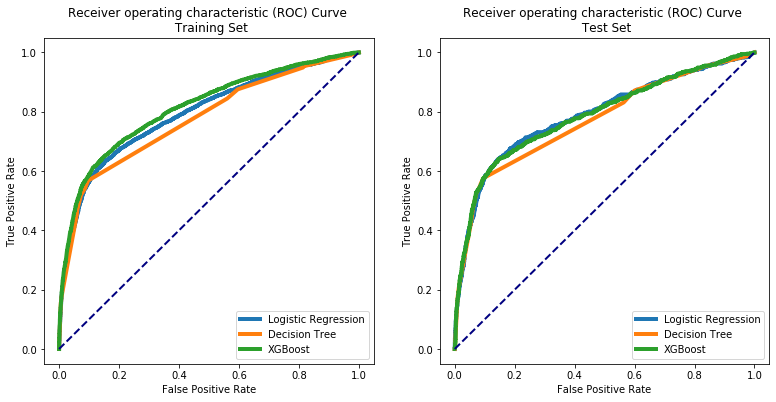

,Model,Time,Train Accuracy,Test Accuracy,Train F1,Test F1,Train Precision,Test Precision,Train Recall,Test Recall,Test Profit
0,Logistic Regression,3.87,0.82,0.83,0.45,0.45,0.34,0.35,0.63,0.64,34400
1,Decision Tree,15.49,0.87,0.87,0.49,0.49,0.43,0.43,0.57,0.58,33160
2,XGBoost,94.58,0.89,0.89,0.50,0.49,0.51,0.50,0.50,0.48,33960


In [106]:
rscv_results = batch_clf(X_train.values, y_train.values, X_test.values, y_test.values, rscv_dict)
rscv_results

Now that we have performed cross validation and optimized hyperparameter choices, we will select our best model based on the table above.

We will focus on our Test Profit metric which we defined specifically for our scenario.

In [107]:
# Get top models based on test profit
rscv_results.sort_values('Test Accuracy', ascending = False)[:3][['Model', 'Test Recall', 'Test Profit']]

,Model,Test Recall,Test Profit
2,XGBoost,0.48,33960
1,Decision Tree,0.58,33160
0,Logistic Regression,0.64,34400


XGBoost performs well in terms of F1 score, Accuracy and Recall. As such we will select this classifier for this project.

Tuning the hyperparameters might improve the result.


<font size="4"><b>XGBoost

The XGBoost classifier has been chosen as the final classifier. Let us now apply GridSearchCV to exhaustively check all hyperparameter combinations. We will also increase cross validation to 5.

In [109]:
# Instantiate classifier
xgboost = xgb.XGBClassifier(random_state = random_state)

# Define pipeline
pipeline = Pipeline([('smote', smote), ('clf', xgboost)])

# Define parameter grid
XGB_params = {
    'clf__n_estimators': [20, 50, 100,200],
    'clf__max_depth': [3, 5, 10, 20],
    'clf__min_child_weight': [2, 3, 5]
}

# Set cv to 5
cv = 5

# Define GridSearch
gs_xgboost = GridSearchCV(estimator = pipeline, 
                          param_grid = XGB_params,
                          scoring = scoring,
                          cv = cv)

# Fit classifier
gs_xgboost_fitted = gs_xgboost.fit(X_train.values,y_train.values)
        
# Get Predictions
train_preds = gs_xgboost_fitted.predict(X_train.values)
test_preds = gs_xgboost_fitted.predict(X_test.values)

# Get Probabilities
train_hat = gs_xgboost_fitted.predict_proba(X_train.values)
train_proba = train_hat[:,1]
test_hat = gs_xgboost_fitted.predict_proba(X_test.values)
test_proba = test_hat[:,1]

In [110]:
# Get classification report
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5890
           1       0.48      0.52      0.50       748

    accuracy                           0.88      6638
   macro avg       0.71      0.72      0.71      6638
weighted avg       0.89      0.88      0.88      6638



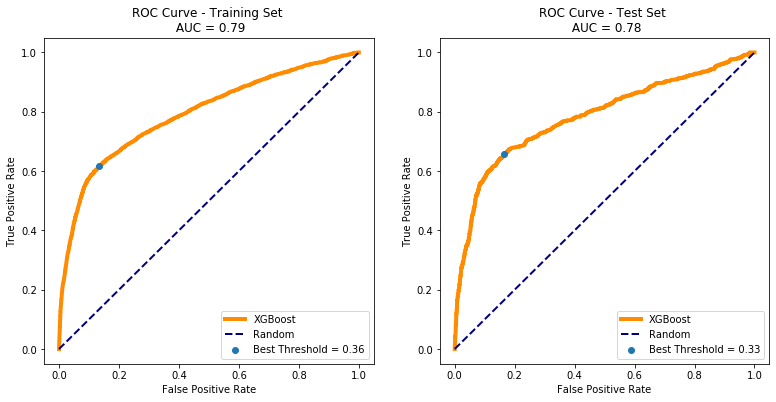

In [111]:
ROC_plot('XGBoost', y_train.values, y_test.values, train_proba, test_proba)

We note that performance on train and test set is comparable with no overfitting.

Let us investigate the best choice of hyperparameters, as determined by GridSearchCV.

In [112]:
# Get best parameters
XGB_best_params = gs_xgboost.best_params_
XGB_best_params

{'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__n_estimators': 20}

<font size="4"><b>Interpret

Now that we have selected and tuned our model, let us look to draw conclusions from it and apply it to the unseen data.

<font size="4"><b>Key Features


Let us investigate the most important features as determined by the XGBoost classifier.

In [113]:
# Get feature importances
gs_xgboost.best_estimator_[1].feature_importances_

array([0.06735056, 0.01836977, 0.        , 0.01121603, 0.0269417 ,
       0.00493925, 0.01012609, 0.01152629, 0.        , 0.02305596,
       0.00630222, 0.02403155, 0.        , 0.00733919, 0.01321968,
       0.0142529 , 0.03684426, 0.01166975, 0.        , 0.03972035,
       0.02991525, 0.        , 0.        , 0.03157924, 0.        ,
       0.03918786, 0.        , 0.02065207, 0.        , 0.00720138,
       0.        , 0.        , 0.00227082, 0.        , 0.01160693,
       0.        , 0.        , 0.01328512, 0.        , 0.04262178,
       0.03130973, 0.0338481 , 0.04039959, 0.09899349, 0.00749485,
       0.        , 0.01343805, 0.00118009, 0.        , 0.01440411,
       0.00311861, 0.04267051, 0.01871534, 0.16920154], dtype=float32)

We see that there are a number of features which have been set to 0 as their effect is insignificant. In this way, XGBoost can also be used to perform feature selection.

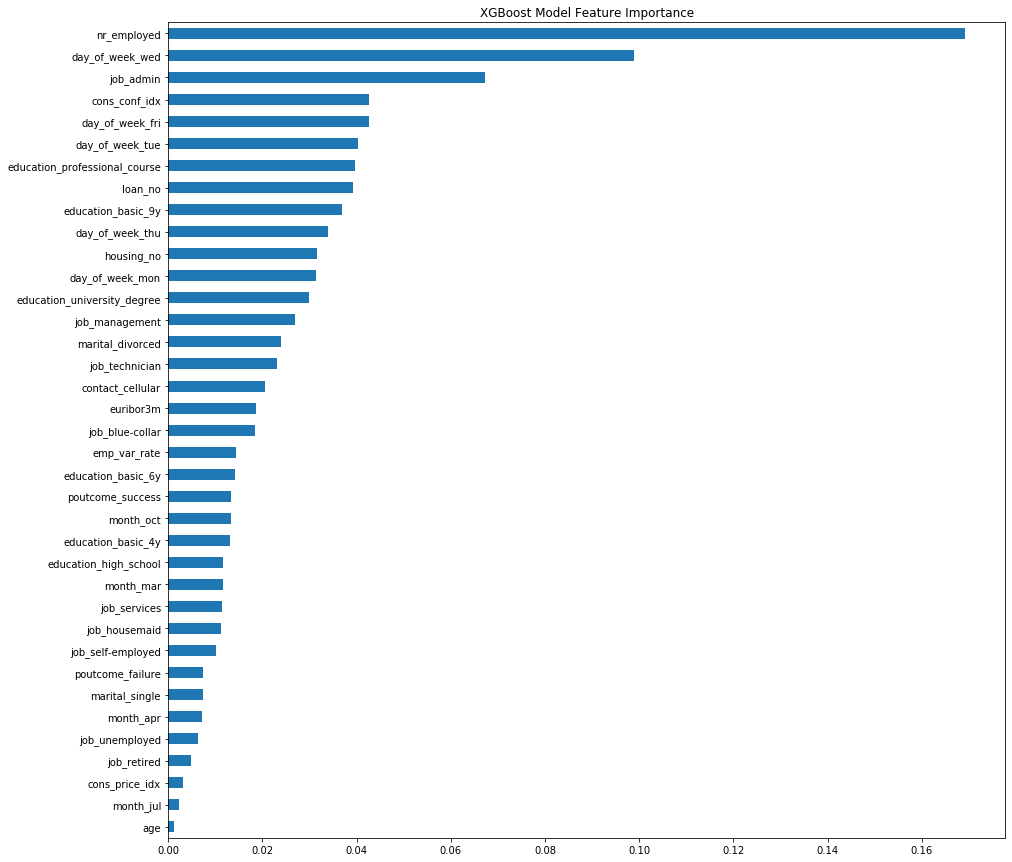

In [114]:
# Create Pandas series with feature importances 
feats = pd.Series(gs_xgboost.best_estimator_[1].feature_importances_, index = X_train.columns)
# Sort values
feats = feats.sort_values(ascending = True)
# Drop null values
feats = feats[feats != 0]
# Plot bar plot
feats.plot(kind = 'barh', figsize = (15,15))
plt.title('XGBoost Model Feature Importance')
plt.show()

We see that nr_employed the number of employees appears to be the most significant feature in predicting whether a customer will subscribe.

Other important features include:

- job_admin, whether the customer's job falls into the admin category
- housing_no, whether the customer has a housing loan


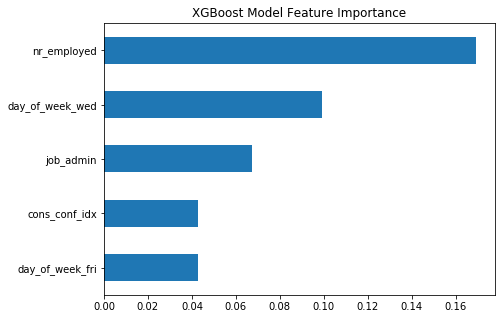

In [115]:
# Plot top 10 for presentation/ README
feats[-5:].plot(kind = 'barh', figsize = (7,5))
plt.title('XGBoost Model Feature Importance')
plt.savefig('Images/feats.pdf', bbox_inches = "tight")
plt.show()

<font size="4"><b>Test Set Predictions


Let us now define our full pipeline including our XGBoost classifier with the chosen hyperparameters.

In [116]:
# Define full pipeline
full_pipeline = Pipeline([
        ('syntaxclean', SyntaxCleanandDrop()),
        ('numprocess', NumPreprocess()),
        ('unknownimputer', UnknownImputer()),
        ('catprocess', cat_process),
        ('smote', smote),
        ('clf', xgb.XGBClassifier(random_state = random_state,
                                  max_depth = 3, 
                                  min_child_weight = 2, 
                                  n_estimators =20 ))
])

Let us fit the pipeline on a copy of the full training set.

In [117]:
# Create copy
df_copy = train_set.reset_index(drop = True)

# Define y
y = df_copy['y']

# Map y values to 1 and 0 
y = y.map(lambda x: 1 if x == 'yes' else 0)

# Define X and check by calling head
X = df_copy.drop('y', axis = 1)
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,53,blue-collar,married,basic.4y,unknown,yes,yes,cellular,nov,fri,98,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8
1,51,admin.,married,university.degree,no,no,no,cellular,jul,mon,455,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
2,34,services,married,high.school,no,no,no,telephone,may,wed,122,5,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
3,39,admin.,single,high.school,no,yes,no,cellular,jul,fri,361,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
4,29,admin.,single,university.degree,no,yes,no,cellular,may,wed,215,3,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1


In [118]:
# Fit pipeline onto training set
full_pipeline.fit(X,y)

Pipeline(steps=[('syntaxclean', SyntaxCleanandDrop()),
                ('numprocess', NumPreprocess()),
                ('unknownimputer', UnknownImputer()),
                ('catprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('smote', SMOTE(random_state=0)),
                (...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000

Now let us define X_test and y_test from the test set we extracted at the start, designed to represent the 8000 customers new to the bank.

In [119]:
# Define X_test
X_test = test_set.drop('y', axis =1 ).reset_index(drop = True)

# Define y_test
y_test = test_set['y'].reset_index(drop = True)

# Map y values to 1 and 0 
y_test = y_test.map(lambda x: 1 if x == 'yes' else 0)

# Get test set predictions
test_preds = full_pipeline.predict(X_test)

In [120]:
print('Classification Report for Test set')
print(classification_report(y_test, test_preds))

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      7099
           1       0.28      0.65      0.39       901

    accuracy                           0.77      8000
   macro avg       0.61      0.72      0.62      8000
weighted avg       0.87      0.77      0.80      8000



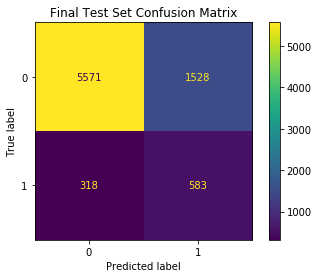

In [121]:
# Plot confusion matrix
plot_confusion_matrix(full_pipeline, X_test, y_test, values_format = '.0f')
plt.title('Final Test Set Confusion Matrix')
plt.show()

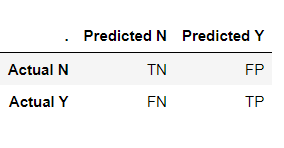

Note that the confusion matrix here is obtained by setting the threshold at 0.5 and therefore not particularly insightful for our case.

Let us look at ROC/AUC.

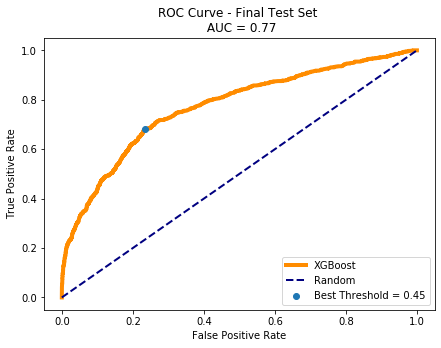

In [122]:
# Predict probabilities on test set
test_hat = full_pipeline.predict_proba(X_test)

# Take class 'y' probabilities
test_proba = test_hat[:,1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_proba)

# Get best threshold using Youden's J statistic
J_test = tpr_test - fpr_test
ix_test = np.argmax(J_test)
best_test_t = round(thresholds_test[ix_test],3)

# Plot ROC curve
plt.figure(figsize = (7,5))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=4, label= 'XGBoost')
plt.scatter(fpr_test[ix_test], tpr_test[ix_test], marker='o', 
                zorder = 3, label=f'Best Threshold = {best_test_t:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title(f'ROC Curve - Final Test Set \n AUC = {round(auc(fpr_test, tpr_test),2)}')
plt.show()

We can now compute the expected profit based on the cost matrix.

Recall that a subscription is valued at EUR 100 and a call cost at EUR 10.

In [123]:
best_t, best_profit = profit_threshold_optimizer(y_test, test_proba)
print(f'Test Profit: € {best_profit}')

Test Profit: € 38030


In comparison, a random model which predicted yes all the time would give the following profit.

In [124]:
y_test_pred = np.ones(len(y_test))
best_t, best_profit = profit_threshold_optimizer(y_test, y_test_pred)
print(f'Test Profit: € {best_profit}')

Test Profit: € 10100


<font size="4"><b>Answer to the Initial Problem

Let us now seek to answer the question in the problem statement.

The bank has a limit of 2500 calls (i.e. 2500 "y" predictions) it can make. We will retrieve the class probabilities and choose the 2500 customers with the highest probability of being of class "y" = yes.

In [125]:
# Get probabilities
pos_proba = full_pipeline.predict_proba(X_test)[:,1]

# Transform into Pandas Series
pos_proba_s = pd.Series(pos_proba)

# Concatenate dataframes to be able to get attributes
test_set_with_proba = pd.concat([X_test, y_test, pos_proba_s], axis = 1)

# Rename column
test_set_with_proba = test_set_with_proba.rename(columns = {0: 'yes_proba'})

# View dataframe
test_set_with_proba.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,yes_proba
0,45,blue-collar,married,unknown,no,yes,no,cellular,apr,thu,...,999,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1,0,0.429665
1,27,services,single,high_school,no,no,no,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,0.175446
2,39,admin,single,high_school,no,yes,no,cellular,oct,fri,...,999,0,nonexistent,-3.4,92.431,-26.9,0.739,5017.5,0,0.771703
3,32,technician,married,professional_course,no,yes,no,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,0.670255
4,53,services,divorced,basic_9y,no,no,no,cellular,jul,fri,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,0,0.188680


We will now extract the top 2500 customers based on the probability of subscribing. These are the customers that should be contacted for the campaign.

In [126]:
# Get top 2500
top_2500 = test_set_with_proba.sort_values('yes_proba', ascending = False)[:2500]
top_2500.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,yes_proba
4985,55,unemployed,divorced,university_degree,no,no,no,cellular,mar,tue,...,6,3,success,-1.8,93.369,-34.8,0.652,5008.7,1,0.933726
6240,68,retired,divorced,basic_4y,no,yes,no,cellular,mar,tue,...,11,1,success,-1.8,93.369,-34.8,0.635,5008.7,1,0.932356
2905,36,admin,single,university_degree,no,no,no,cellular,jun,wed,...,7,1,success,-1.7,94.055,-39.8,0.739,4991.6,1,0.925625
6465,27,student,single,university_degree,no,no,no,cellular,aug,wed,...,3,3,success,-1.7,94.027,-38.3,0.900,4991.6,1,0.925625
4552,29,admin,single,university_degree,no,yes,no,cellular,jun,wed,...,6,3,success,-1.7,94.055,-39.8,0.715,4991.6,1,0.921254


-----------

We now look at whether these customers actually subscribed to determine revenue. Let us get the number of subscribers by counting the number of y = 1 values.

In [127]:
# Get num of y
top_2500['y'].value_counts()

0    1865
1     635
Name: y, dtype: int64

Out of the 2500 customers contacted, 635 subscribed to the term deposit.

Recall our initial revenue estimations:

The value per subscription is estimated at EUR 100. In general, we know that uptake for these type of campaigns is small, with the proportion of successful calls around 10-15%. As such, by contacting 2500 customers randomly, we would expect revenue to be between EUR 25.000 and EUR 37.500.

By using the available data and machine learning techniques, we were able to increase revenue to .

<font size="5"><b>Final Test

Suppose the stakeholders wish to change the number of calls or the subscription value. We present a small function that allows for user interaction to set the number of calls and subscription value.

In [128]:
call_num = 2500
subscription_value = 100
call_cost = 10

In [129]:
def revenue_calculator(test_set_with_proba, call_num, subscription_value, call_cost, verbose = True):
    ''' 
    Calculates revenue for specified number of calls and subscription value
    Args: 
        test_set_with_proba: dataframe with probabilities 'yes_proba' column and labels `y` column
        call_num: number of calls
        subscription_value: value of a subscription
        call_cost: cost associated to a call
        verbose: print expected revenue with call_num and subscription_value and actual revenue, 
                 default True
    Returns:
        revenue

    '''
    call_num = input("Number of calls:")
    call_num = int(call_num)
    subscription_value = input("Subscription value:")
    subscription_value = int(subscription_value)
    call_cost = input("Cost per call:")
    call_cost = int(call_cost)

    top_customers = test_set_with_proba.sort_values('yes_proba', ascending = False)[:call_num]
    num_yes = len(top_customers[top_customers['y'] == 1])
    revenue = subscription_value * num_yes
    profit = subscription_value * num_yes - call_num * call_cost
    
    expected_min = int(0.1*call_num*subscription_value)
    expected_max = int(0.15*call_num*subscription_value)
    
    if verbose:
        print(f'The expected revenue for {call_num} calls and with a '
              f'subscription valued at €{subscription_value} is between €{expected_min} and ' 
              f'€{expected_max}. \n'
              f'The revenue generated using this prediction is €{revenue}.\n'
              f'The expected profit using this predictions is €{profit}.'
            )
    return revenue


In [136]:
revenue_calculator(test_set_with_proba, call_num, subscription_value, call_cost)

Number of calls:2500
Subscription value:100
Cost per call:10
The expected revenue for 2500 calls and with a subscription valued at $100 is between €25000 and €37500. 
The revenue generated using our predictions is €63500.
The expected profit using our predictions is €38500.


63500

<font size="5"><b>Conclusion

<font size="4"><b>Summary of Findings and Insights

In this hypothetical problem, Banco de Portugal needs to select 2500 customers who are most likely to subscribe to a term deposit. They were acquiring 10000 new customers but due to marketing budget constraints were unable to market to all. A subscription was valued at EUR 250 and average uptake is around 10-15%. As such choosing the 2500 customers to target randomly would have resulted in an **expected revenue between EUR 25.000 and EUR 37.500**.

However by gathering data and using an XGBoost classifier (accuracy 88%) , we were able to **increase revenue to EUR 63.500, resulting in an exected profit of 38.500**.

A summary of the **key steps** which led us to this result are as follows:

1. The data was gathered relating to customers' personal profile (job, age, education etc), financial (housing loan, personal loan, default) and economic indices (consumer price index). There were 41,188 entries on which to train the algorithm. 
2. The data was cleansed, replacing unknown values using K-Nearest Neighbours imputation.
3. Due to the low number of positive target outcomes(11,26%) there was a need to adjust for the class imbalance by using SMOTE.
4. A custom profit metric was established by using valuations for revenue and call cost to evaluate the models, together with recall and F1 score.
5. The following classifiers were trained and tuned using RandomizedGridSearchCV: Logistic Regression, Decision Tree and XGBoost. Based on the profit metric, the XGBoost was selected as the best performing model for this classification problem.
6. Further fine-tuning was conducted to select the best paramaters of XGBoost using GridSearchCV.
7. The final model was applied to the test set and chose the 2500 customers with highest probability of being classified as subscribers.


The 5 features which had the highest impact on the classification are:
* `nr_employees`, number of employees (a quarterly metric which represents economic state)
* `job_admin`, whether the customer's job falls into the admin category
* `housing_no`, whether the customer has a housing loan with the bank
* `day_of_week_mon`, whether the customer was contacted during monday
* `day_of_week_thu`, whether the customer was contacted during thursday

**Recommendations**:
* Focus on students and retired customers
* Focus on repeat customers as clients who previously subscribed to a term deposit are more likely to do so again (65%)
* Conduct calls on using cellular channel

Other findings:
* calls which led to a subscription were on average 10 minutes long compare to 4 minutes for one that didn't
* on average it took two phone calls to get a customer to subscribe

**Conclusion**

Response models are an intuitive and effective way to predicting the optimal targets to maximize direct marketing campaign ROI, given the usual constraints on campaign budget.

**Next Steps**

In the next project, the main focus of study will be uplift modeling. The baseline (random) model and the response modell which were the focus of this project, will be subject to comparison agains the revenue generated by uplift models using the same training and test set, with addition to a new synthetic variable called 'offer', with 50% of customers being made an offer, and 50% not.